In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 12
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr.detach())
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())
        
        _loss = _gen + air_loss + bone_loss + _mae + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f7da4275d30>,)

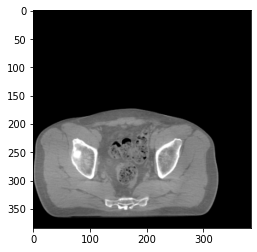

In [22]:
plt.imshow(x.squeeze(), 'gray'),

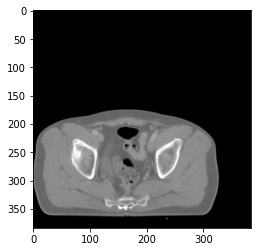

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

112it [02:39,  1.43s/it]
112it [00:39,  2.83it/s]
16it [00:06,  2.64it/s]
112it [02:39,  1.42s/it]
112it [00:39,  2.86it/s]
16it [00:05,  2.68it/s]
112it [02:39,  1.42s/it]
112it [00:39,  2.87it/s]
16it [00:05,  2.69it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.88it/s]
16it [00:05,  2.70it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.89it/s]
16it [00:05,  2.70it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.89it/s]
16it [00:05,  2.70it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.90it/s]
16it [00:05,  2.70it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.90it/s]
16it [00:05,  2.72it/s]
112it [02:39,  1.43s/it]
112it [00:38,  2.89it/s]
16it [00:05,  2.72it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.89it/s]
16it [00:05,  2.71it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.90it/s]
16it [00:05,  2.71it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.89it/s]
16it [00:05,  2.71it/s]
112it [02:39,  1.42s/it]
112it [00:38,  2.90it/s]
16it [00:05,  2.71it/s]
112it [02:39,  1.42s/it]
112it [00:38,

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8901921510696411
psnr score = 25.282480239868164
snr score = 15.345417022705078
mae error = 0.017523733898997307
air dice score = 0.9983663668392166
bone dice score = 0.9468325791862722
contour dice score = 0.8327359557151794


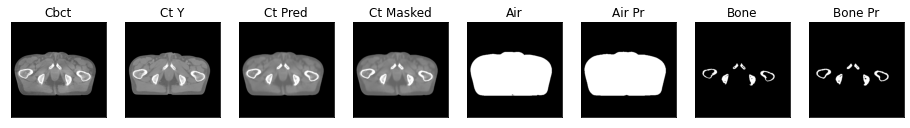

ssim score = 0.8898867964744568
psnr score = 25.213289260864258
snr score = 15.323762893676758
mae error = 0.017673322930932045
air dice score = 0.9983480825958718
bone dice score = 0.9438170918730822
contour dice score = 0.826347291469574


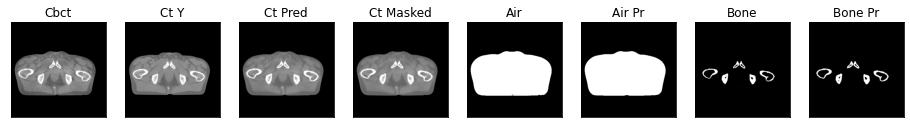

ssim score = 0.8867927193641663
psnr score = 24.99078941345215
snr score = 15.26416015625
mae error = 0.018915677443146706
air dice score = 0.9981312088128277
bone dice score = 0.9406799531073776
contour dice score = 0.7932894229888916


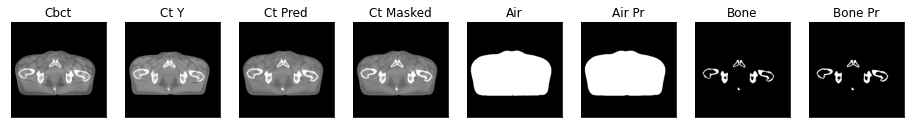

ssim score = 0.8836931586265564
psnr score = 25.034622192382812
snr score = 15.397244453430176
mae error = 0.018925562500953674
air dice score = 0.9978019378431413
bone dice score = 0.9373027561546675
contour dice score = 0.7525464296340942


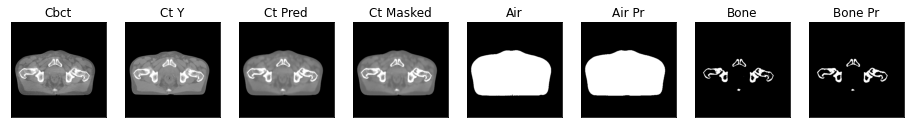

ssim score = 0.8804594874382019
psnr score = 25.02805519104004
snr score = 15.43097972869873
mae error = 0.01902582310140133
air dice score = 0.997665769900303
bone dice score = 0.9336123264225451
contour dice score = 0.7336139678955078


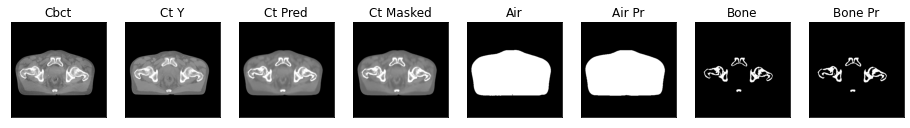

ssim score = 0.8734212517738342
psnr score = 24.797456741333008
snr score = 15.3369140625
mae error = 0.02013995125889778
air dice score = 0.9978248562319381
bone dice score = 0.9398290046786593
contour dice score = 0.7471333742141724


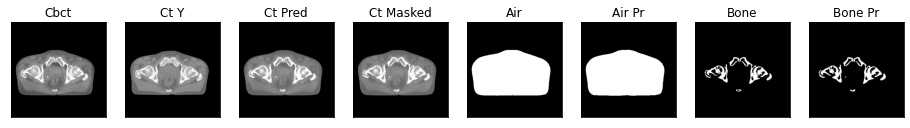

ssim score = 0.8713126182556152
psnr score = 24.748685836791992
snr score = 15.264089584350586
mae error = 0.020242862403392792
air dice score = 0.9983703748137944
bone dice score = 0.9432640672430286
contour dice score = 0.8234582543373108


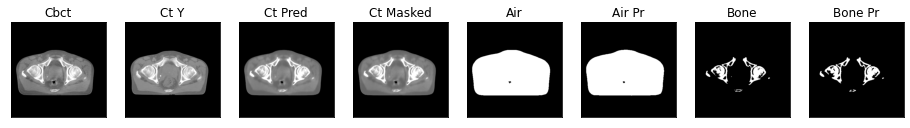

ssim score = 0.8736017942428589
psnr score = 25.06629180908203
snr score = 15.396158218383789
mae error = 0.019360369071364403
air dice score = 0.9984320662552532
bone dice score = 0.9469155983829741
contour dice score = 0.8354583978652954


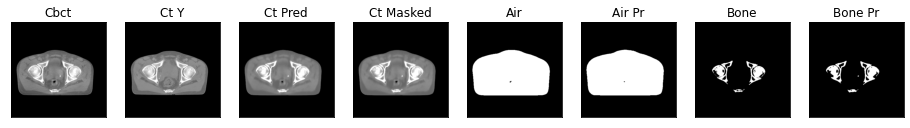

ssim score = 0.8771748542785645
psnr score = 25.36447525024414
snr score = 15.599786758422852
mae error = 0.018613973632454872
air dice score = 0.998736033166491
bone dice score = 0.949587706147399
contour dice score = 0.8533170819282532


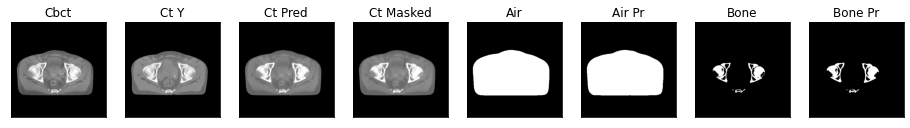

ssim score = 0.8798926472663879
psnr score = 25.49842643737793
snr score = 15.718451499938965
mae error = 0.018393123522400856
air dice score = 0.9983920538967267
bone dice score = 0.9512433914240137
contour dice score = 0.8437118530273438


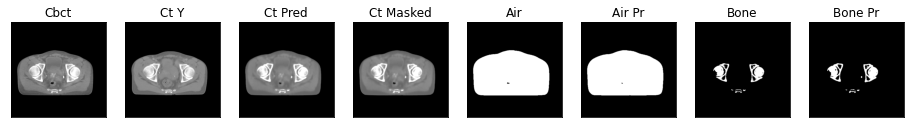

ssim score = 0.8873589038848877
psnr score = 25.902978897094727
snr score = 16.155275344848633
mae error = 0.01754377968609333
air dice score = 0.9984029484029501
bone dice score = 0.9632253359728803
contour dice score = 0.8215159177780151


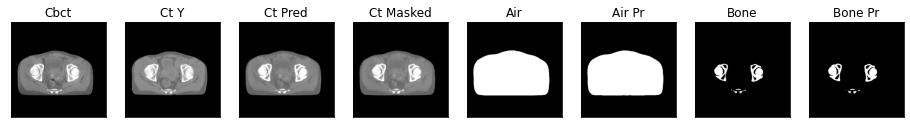

ssim score = 0.8869614601135254
psnr score = 25.317832946777344
snr score = 15.593842506408691
mae error = 0.018058830872178078
air dice score = 0.9975464060542715
bone dice score = 0.9614578969421715
contour dice score = 0.7579461932182312


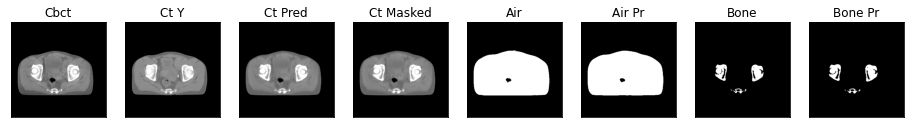

1it [00:04,  4.56s/it]

ssim score = 0.8926801681518555
psnr score = 24.81928825378418
snr score = 15.063373565673828
mae error = 0.018223121762275696
air dice score = 0.997476519062231
bone dice score = 0.9649378290583069
contour dice score = 0.7561274766921997


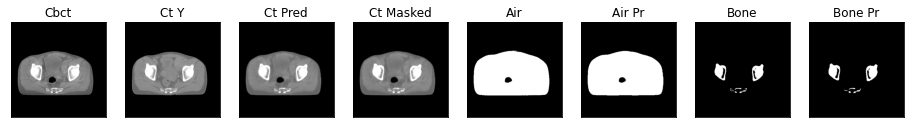

ssim score = 0.8882174491882324
psnr score = 24.558170318603516
snr score = 14.660297393798828
mae error = 0.018879298120737076
air dice score = 0.9971594808924962
bone dice score = 0.9477051802639632
contour dice score = 0.7358024716377258


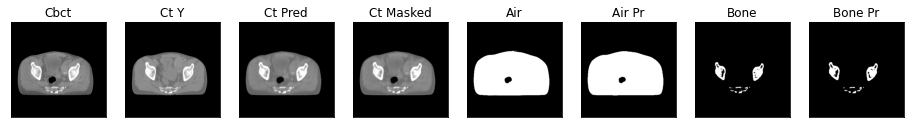

ssim score = 0.8864187002182007
psnr score = 24.49979019165039
snr score = 14.516258239746094
mae error = 0.019280241802334785
air dice score = 0.9975574529544226
bone dice score = 0.9309762121418046
contour dice score = 0.7925925850868225


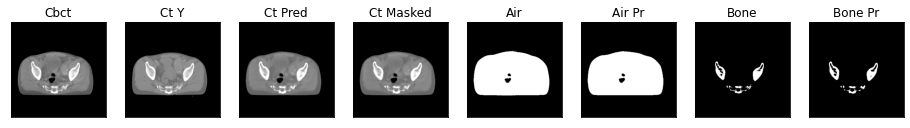

ssim score = 0.8788076043128967
psnr score = 24.163536071777344
snr score = 14.203487396240234
mae error = 0.02021190896630287
air dice score = 0.9983979151535882
bone dice score = 0.9391261659310367
contour dice score = 0.8829054236412048


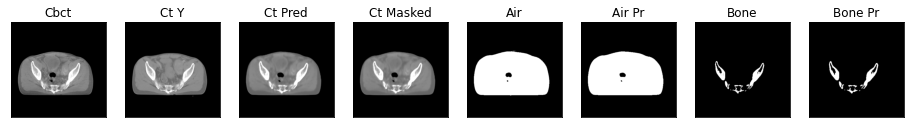

ssim score = 0.8762128949165344
psnr score = 23.507678985595703
snr score = 13.545085906982422
mae error = 0.02132781222462654
air dice score = 0.9978178204131041
bone dice score = 0.9401908308128903
contour dice score = 0.8449466228485107


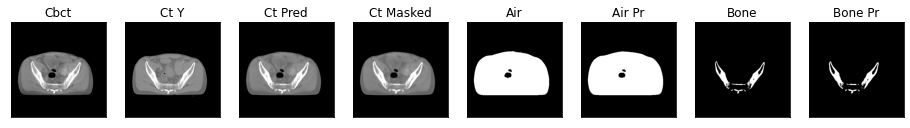

ssim score = 0.8686577677726746
psnr score = 22.967185974121094
snr score = 12.90283203125
mae error = 0.022582659497857094
air dice score = 0.9968774565464267
bone dice score = 0.9230769230778305
contour dice score = 0.8004956841468811


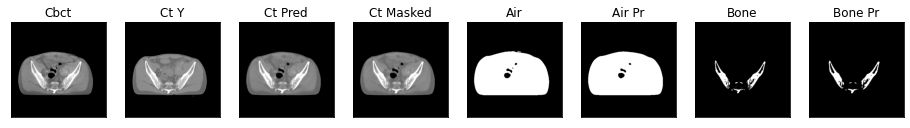

ssim score = 0.8653768301010132
psnr score = 22.669469833374023
snr score = 12.554434776306152
mae error = 0.02334817871451378
air dice score = 0.9962732099864822
bone dice score = 0.9145416953834763
contour dice score = 0.8245054483413696


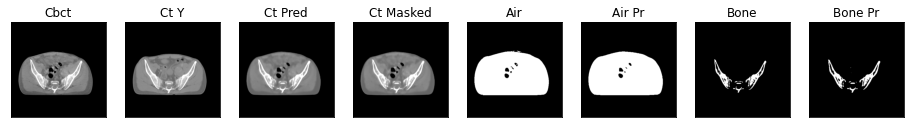

ssim score = 0.8696027398109436
psnr score = 22.654430389404297
snr score = 12.527085304260254
mae error = 0.02329707145690918
air dice score = 0.9966136207697963
bone dice score = 0.9249383296144139
contour dice score = 0.7703045606613159


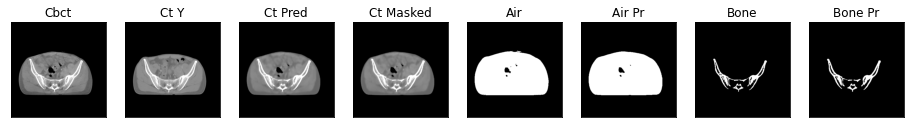

ssim score = 0.8679856657981873
psnr score = 22.52039909362793
snr score = 12.328208923339844
mae error = 0.023394323885440826
air dice score = 0.9972529926746502
bone dice score = 0.916069600819907
contour dice score = 0.778205156326294


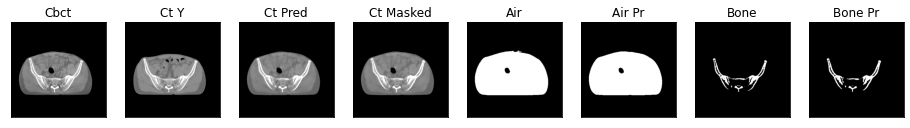

ssim score = 0.866932213306427
psnr score = 22.584001541137695
snr score = 12.332381248474121
mae error = 0.022884005680680275
air dice score = 0.995468702564742
bone dice score = 0.9233475747684927
contour dice score = 0.6946417093276978


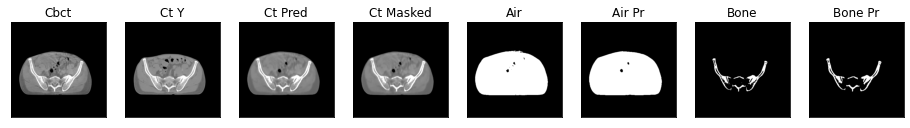

ssim score = 0.870995283126831
psnr score = 22.693607330322266
snr score = 12.408557891845703
mae error = 0.022593406960368156
air dice score = 0.9962023877202999
bone dice score = 0.926777998365914
contour dice score = 0.7207792401313782


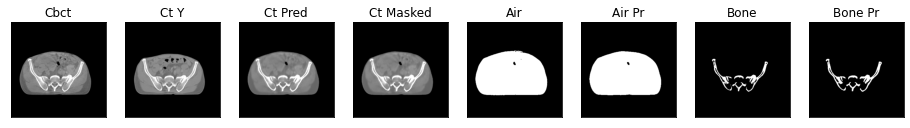

ssim score = 0.8716332316398621
psnr score = 22.692564010620117
snr score = 12.3589506149292
mae error = 0.02277061715722084
air dice score = 0.995866629925604
bone dice score = 0.9218060427755821
contour dice score = 0.6887417435646057


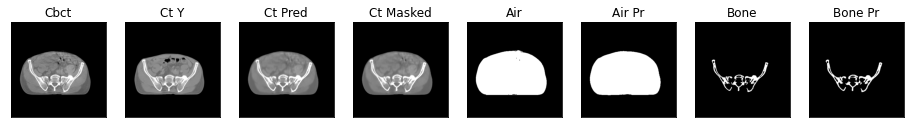

2it [00:08,  4.30s/it]

ssim score = 0.8736897110939026
psnr score = 22.626850128173828
snr score = 12.196239471435547
mae error = 0.022851958870887756
air dice score = 0.9954666759897033
bone dice score = 0.9292818887317819
contour dice score = 0.6214765310287476


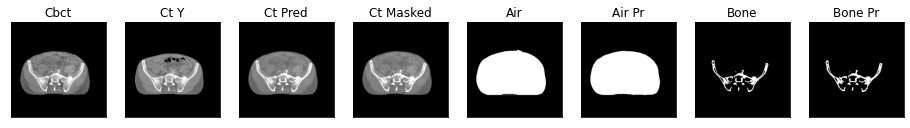

ssim score = 0.8797782063484192
psnr score = 22.980567932128906
snr score = 12.4672212600708
mae error = 0.02161974459886551
air dice score = 0.9954977488744425
bone dice score = 0.9198989122083299
contour dice score = 0.6829931735992432


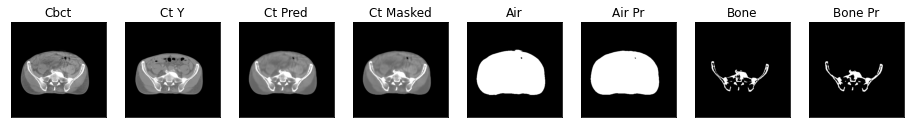

ssim score = 0.8807840943336487
psnr score = 23.1278018951416
snr score = 12.523269653320312
mae error = 0.021458327770233154
air dice score = 0.9950421658930237
bone dice score = 0.9292907649461186
contour dice score = 0.6787456274032593


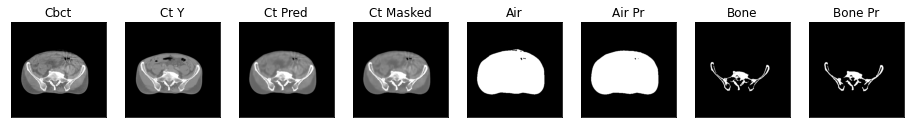

ssim score = 0.8793358206748962
psnr score = 22.917579650878906
snr score = 12.271940231323242
mae error = 0.02190271206200123
air dice score = 0.9945084101538947
bone dice score = 0.9309745372744558
contour dice score = 0.6483050584793091


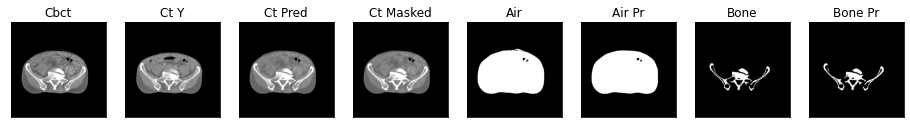

ssim score = 0.8745009899139404
psnr score = 24.08013153076172
snr score = 15.452288627624512
mae error = 0.02120765671133995
air dice score = 0.996610588053714
bone dice score = 0.9722308892364359
contour dice score = 0.6729533076286316


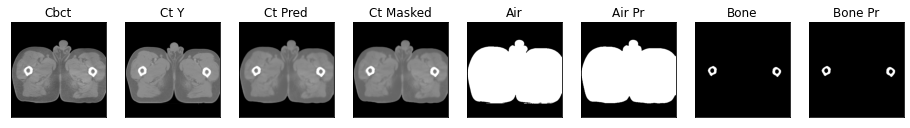

ssim score = 0.8808172941207886
psnr score = 24.754344940185547
snr score = 16.165761947631836
mae error = 0.01973821222782135
air dice score = 0.9963488694950209
bone dice score = 0.9754672897203427
contour dice score = 0.6548373699188232


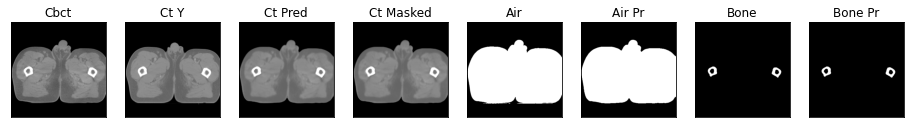

ssim score = 0.8842676877975464
psnr score = 25.186384201049805
snr score = 16.68524742126465
mae error = 0.019256629049777985
air dice score = 0.9966413808601243
bone dice score = 0.9671296296303905
contour dice score = 0.6829268336296082


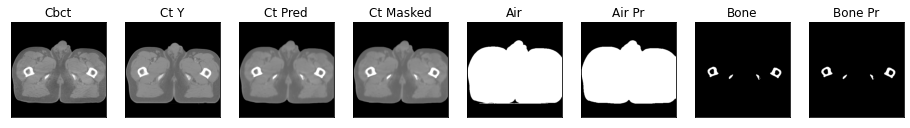

ssim score = 0.8841705322265625
psnr score = 25.21957778930664
snr score = 16.881000518798828
mae error = 0.01987328939139843
air dice score = 0.99794708304653
bone dice score = 0.9686028257461757
contour dice score = 0.7912288904190063


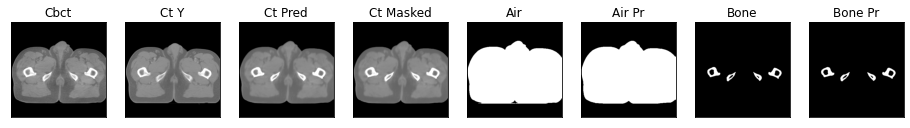

ssim score = 0.8844290375709534
psnr score = 25.485877990722656
snr score = 17.275440216064453
mae error = 0.01948981173336506
air dice score = 0.9982027253656173
bone dice score = 0.9521119182142573
contour dice score = 0.80074143409729


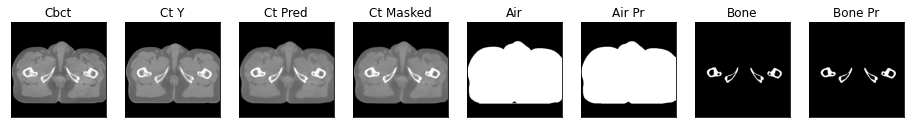

ssim score = 0.8844049572944641
psnr score = 25.82386016845703
snr score = 17.716663360595703
mae error = 0.019358962774276733
air dice score = 0.9984072428535511
bone dice score = 0.9412040290473037
contour dice score = 0.8238557577133179


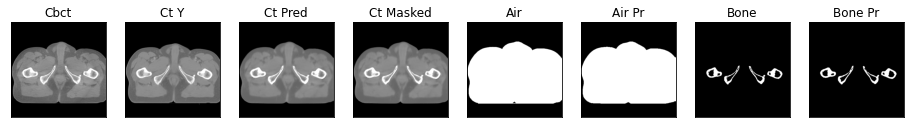

ssim score = 0.8846291899681091
psnr score = 26.082836151123047
snr score = 18.04273796081543
mae error = 0.019487839192152023
air dice score = 0.9984369966472991
bone dice score = 0.9408239700380864
contour dice score = 0.8107357621192932


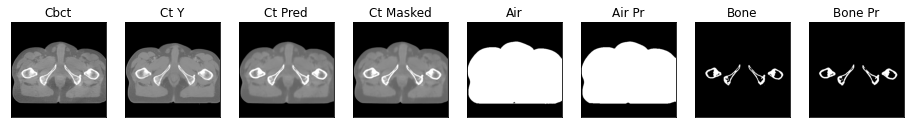

ssim score = 0.8823198676109314
psnr score = 26.016555786132812
snr score = 17.966567993164062
mae error = 0.019672730937600136
air dice score = 0.9984712845373711
bone dice score = 0.9541544378104022
contour dice score = 0.8105117678642273


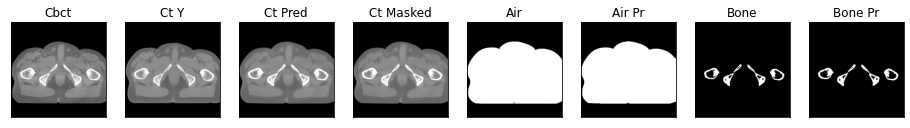

3it [00:11,  4.13s/it]

ssim score = 0.8827479481697083
psnr score = 26.08301544189453
snr score = 18.019363403320312
mae error = 0.019190892577171326
air dice score = 0.9984449008179118
bone dice score = 0.9596936719068955
contour dice score = 0.8016605377197266


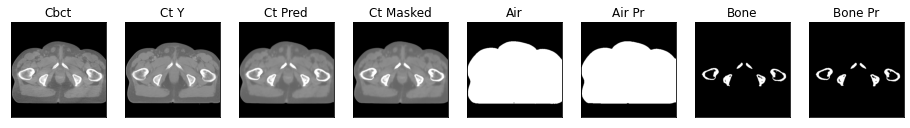

ssim score = 0.8843603134155273
psnr score = 26.239593505859375
snr score = 18.187944412231445
mae error = 0.01900455169379711
air dice score = 0.9983581585295749
bone dice score = 0.9518341307820113
contour dice score = 0.7928010821342468


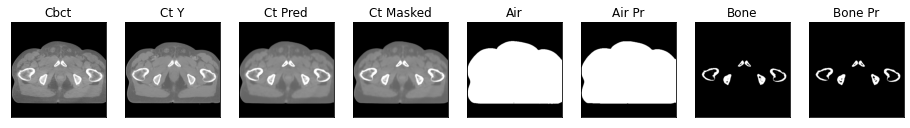

ssim score = 0.8847904801368713
psnr score = 26.204702377319336
snr score = 18.192136764526367
mae error = 0.018904656171798706
air dice score = 0.9983767387852802
bone dice score = 0.9455975529828972
contour dice score = 0.8090614676475525


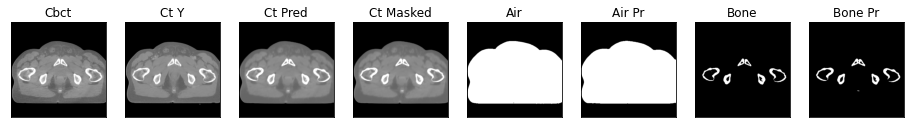

ssim score = 0.8809750080108643
psnr score = 26.045665740966797
snr score = 18.174388885498047
mae error = 0.019645391032099724
air dice score = 0.9985069144082769
bone dice score = 0.9519813519817997
contour dice score = 0.8192771077156067


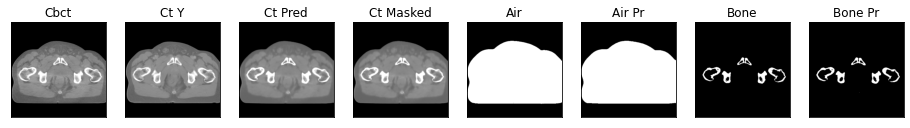

ssim score = 0.8774094581604004
psnr score = 25.91057014465332
snr score = 18.133981704711914
mae error = 0.02071669138967991
air dice score = 0.9986235701741903
bone dice score = 0.9509917419159452
contour dice score = 0.8323270082473755


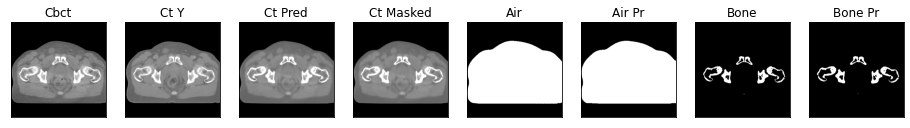

ssim score = 0.8663429617881775
psnr score = 25.294387817382812
snr score = 17.48375129699707
mae error = 0.02277158945798874
air dice score = 0.9981136229745261
bone dice score = 0.9365091291611953
contour dice score = 0.8115402460098267


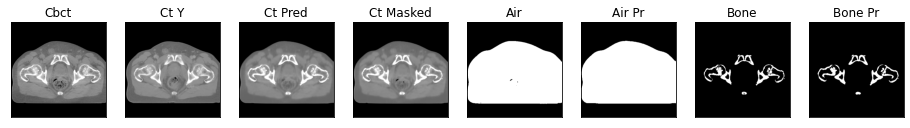

ssim score = 0.8649033308029175
psnr score = 24.819290161132812
snr score = 17.080841064453125
mae error = 0.023317376151680946
air dice score = 0.9979228149150282
bone dice score = 0.9320225082469955
contour dice score = 0.8196721076965332


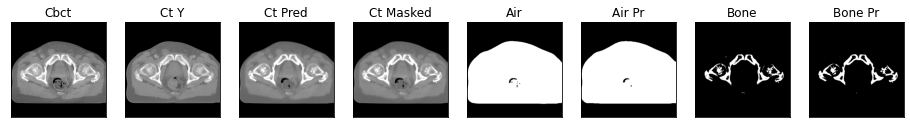

ssim score = 0.8643751740455627
psnr score = 25.076736450195312
snr score = 17.202194213867188
mae error = 0.022260110825300217
air dice score = 0.9980601183147665
bone dice score = 0.9229480737024879
contour dice score = 0.8415609002113342


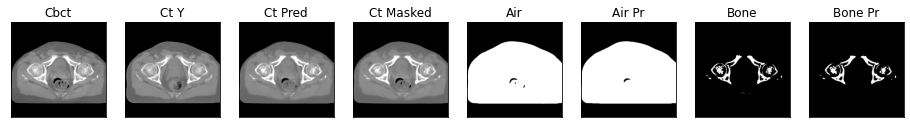

ssim score = 0.8708488345146179
psnr score = 24.91855239868164
snr score = 16.865446090698242
mae error = 0.02197680063545704
air dice score = 0.9978495659978448
bone dice score = 0.917664670659453
contour dice score = 0.8099952936172485


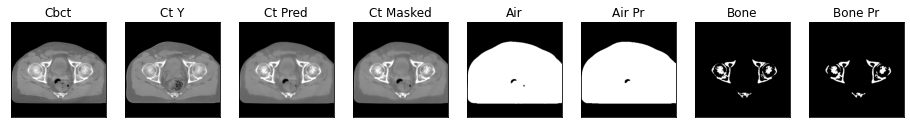

ssim score = 0.8698615431785583
psnr score = 25.054485321044922
snr score = 16.910791397094727
mae error = 0.021841196343302727
air dice score = 0.9985212904004596
bone dice score = 0.902741030797939
contour dice score = 0.8257575631141663


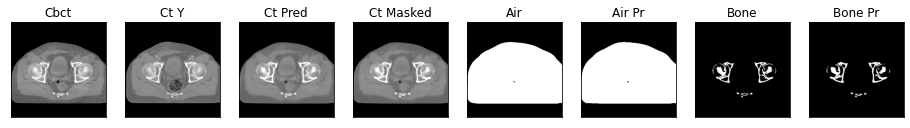

ssim score = 0.8691035509109497
psnr score = 25.007144927978516
snr score = 16.879140853881836
mae error = 0.02175186760723591
air dice score = 0.9986356773407238
bone dice score = 0.9258154335727345
contour dice score = 0.8269321918487549


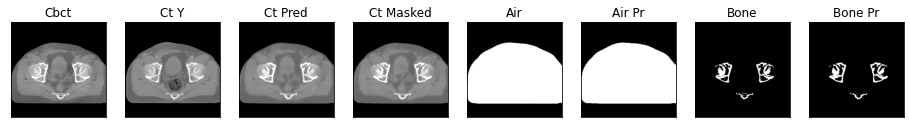

ssim score = 0.8579874038696289
psnr score = 24.729293823242188
snr score = 16.611326217651367
mae error = 0.02306383289396763
air dice score = 0.9987444077383499
bone dice score = 0.9321502195936887
contour dice score = 0.8376068472862244


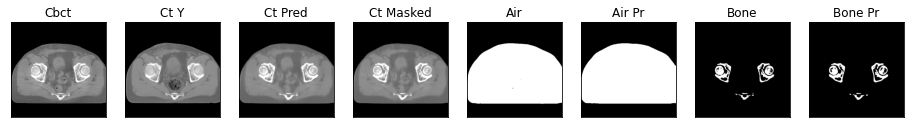

4it [00:15,  4.01s/it]

ssim score = 0.8659405708312988
psnr score = 25.253643035888672
snr score = 17.197263717651367
mae error = 0.021613305434584618
air dice score = 0.9985565396095326
bone dice score = 0.9500662836946525
contour dice score = 0.8205128312110901


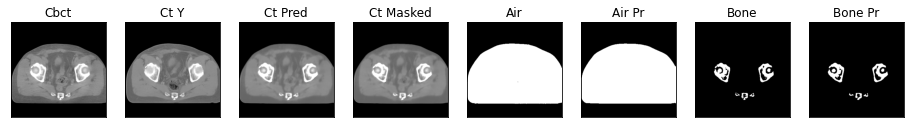

ssim score = 0.8695147037506104
psnr score = 25.884902954101562
snr score = 17.898605346679688
mae error = 0.020627053454518318
air dice score = 0.9983141555758548
bone dice score = 0.9660610215978226
contour dice score = 0.7939221262931824


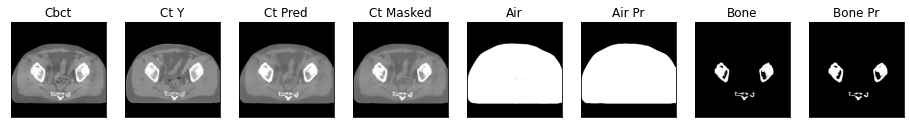

ssim score = 0.8677392601966858
psnr score = 25.284921646118164
snr score = 17.179519653320312
mae error = 0.021592237055301666
air dice score = 0.9982470549296995
bone dice score = 0.9568605093124586
contour dice score = 0.7912713289260864


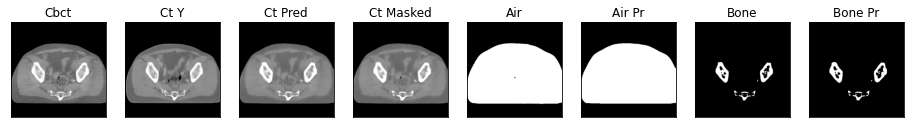

ssim score = 0.8599913716316223
psnr score = 24.70470428466797
snr score = 16.68092918395996
mae error = 0.023747438564896584
air dice score = 0.9978328476626602
bone dice score = 0.9575577066273058
contour dice score = 0.7788369655609131


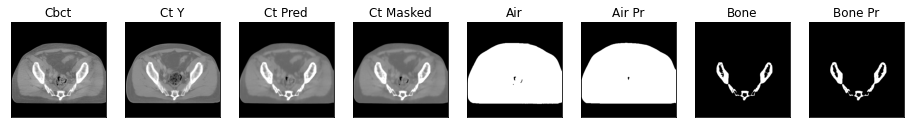

ssim score = 0.8587270975112915
psnr score = 24.708040237426758
snr score = 16.7644100189209
mae error = 0.023750776425004005
air dice score = 0.9976352404172257
bone dice score = 0.9548830811557436
contour dice score = 0.75789475440979


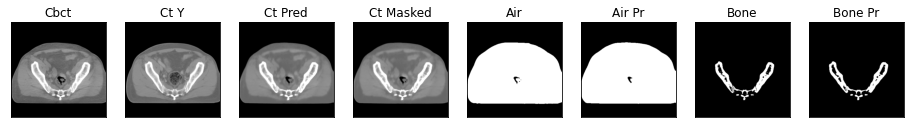

ssim score = 0.8476845026016235
psnr score = 24.224044799804688
snr score = 16.30197525024414
mae error = 0.02552603743970394
air dice score = 0.9978049048182352
bone dice score = 0.9449503311262075
contour dice score = 0.7574304938316345


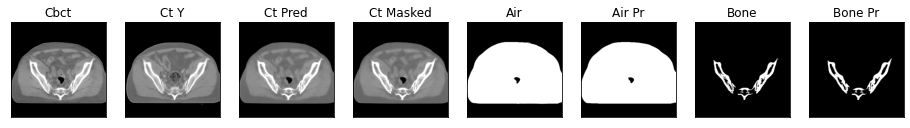

ssim score = 0.8463653326034546
psnr score = 24.548450469970703
snr score = 16.638916015625
mae error = 0.025724025443196297
air dice score = 0.9981127966901369
bone dice score = 0.952234636871842
contour dice score = 0.7687888741493225


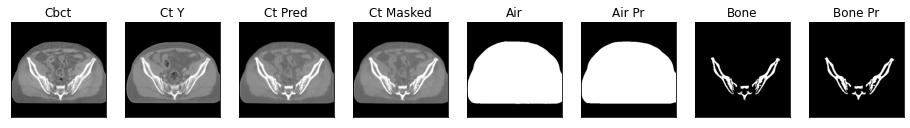

ssim score = 0.8150357007980347
psnr score = 20.755502700805664
snr score = 10.635709762573242
mae error = 0.03391066566109657
air dice score = 0.9967347449970061
bone dice score = 0.9624060150386035
contour dice score = 0.690304696559906


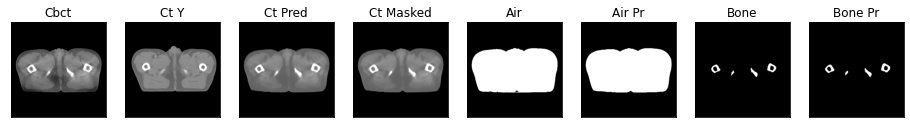

ssim score = 0.8034090995788574
psnr score = 20.38669776916504
snr score = 10.479887008666992
mae error = 0.036341335624456406
air dice score = 0.996512269338224
bone dice score = 0.9442411194845158
contour dice score = 0.6898455023765564


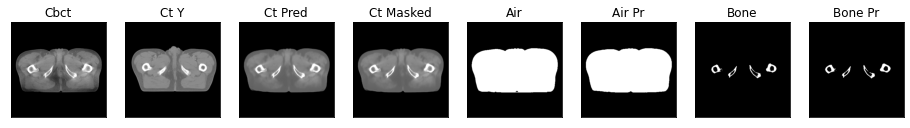

ssim score = 0.7982338666915894
psnr score = 20.384700775146484
snr score = 10.609027862548828
mae error = 0.036860816180706024
air dice score = 0.9961395431202442
bone dice score = 0.9125738740592506
contour dice score = 0.6754675507545471


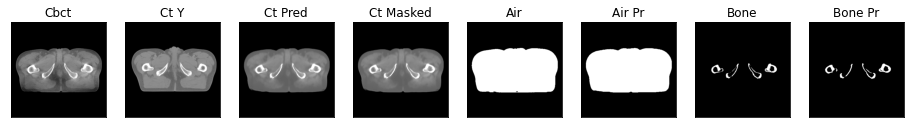

ssim score = 0.8033637404441833
psnr score = 20.743202209472656
snr score = 11.037933349609375
mae error = 0.035610321909189224
air dice score = 0.9946380697050986
bone dice score = 0.9201166180773543
contour dice score = 0.5982437133789062


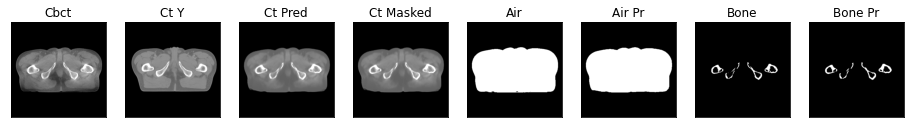

ssim score = 0.8047151565551758
psnr score = 20.818998336791992
snr score = 11.161294937133789
mae error = 0.03539424017071724
air dice score = 0.993862441306303
bone dice score = 0.9131845067751729
contour dice score = 0.5800109505653381


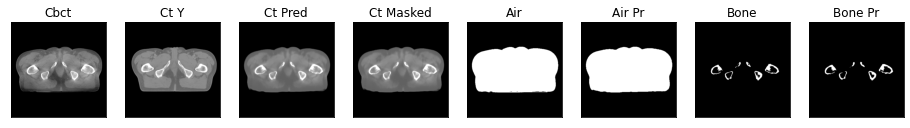

5it [00:19,  3.93s/it]

ssim score = 0.8064287304878235
psnr score = 20.997722625732422
snr score = 11.345634460449219
mae error = 0.03472120314836502
air dice score = 0.9929843023765738
bone dice score = 0.9237883832792492
contour dice score = 0.5847952961921692


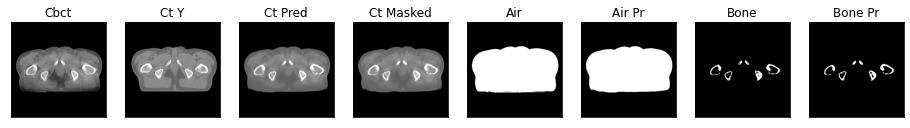

ssim score = 0.8106744289398193
psnr score = 21.110992431640625
snr score = 11.452399253845215
mae error = 0.034050069749355316
air dice score = 0.9926392167147542
bone dice score = 0.9307990404146375
contour dice score = 0.5991471409797668


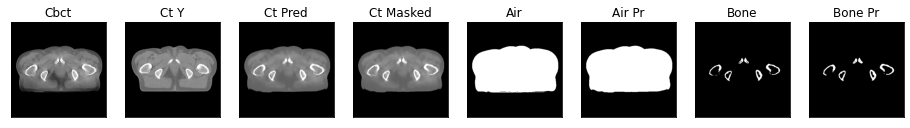

ssim score = 0.8092661499977112
psnr score = 20.951679229736328
snr score = 11.307197570800781
mae error = 0.03450670838356018
air dice score = 0.9932797102963253
bone dice score = 0.9303650935007949
contour dice score = 0.5910543203353882


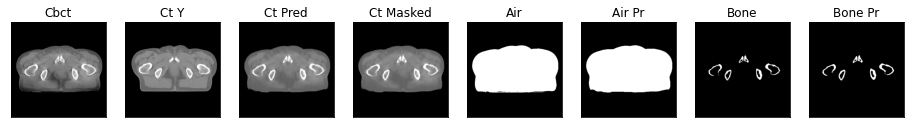

ssim score = 0.8078345656394958
psnr score = 20.897647857666016
snr score = 11.311174392700195
mae error = 0.03514525666832924
air dice score = 0.9942043845091155
bone dice score = 0.921140672296939
contour dice score = 0.6110219359397888


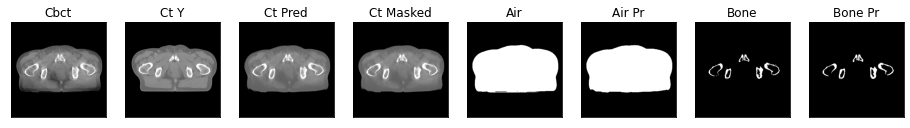

ssim score = 0.7973888516426086
psnr score = 20.734968185424805
snr score = 11.247054100036621
mae error = 0.036879438906908035
air dice score = 0.9937261698440263
bone dice score = 0.9028694184455598
contour dice score = 0.5442032814025879


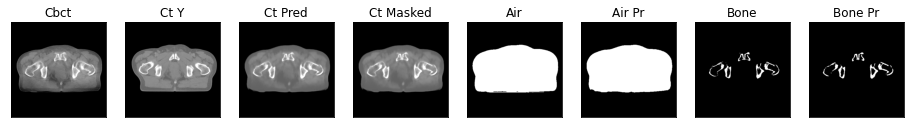

ssim score = 0.786316990852356
psnr score = 20.52889060974121
snr score = 11.076804161071777
mae error = 0.03833433613181114
air dice score = 0.9941282785219571
bone dice score = 0.9002898550739088
contour dice score = 0.5651237964630127


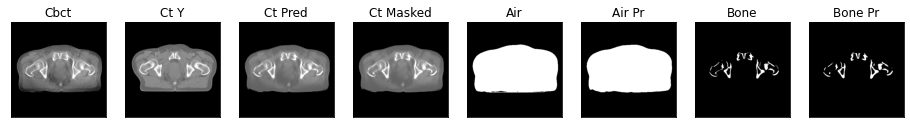

ssim score = 0.7732232213020325
psnr score = 20.329675674438477
snr score = 10.910296440124512
mae error = 0.038902878761291504
air dice score = 0.9949311342342775
bone dice score = 0.8843975283228064
contour dice score = 0.6169527769088745


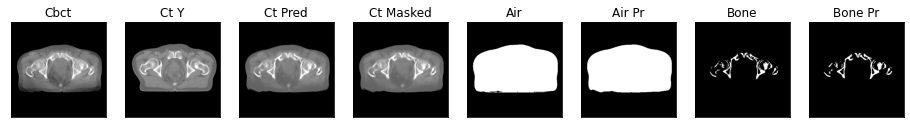

ssim score = 0.7759842276573181
psnr score = 20.434181213378906
snr score = 11.131619453430176
mae error = 0.03946476802229881
air dice score = 0.995590379952197
bone dice score = 0.8957407891312289
contour dice score = 0.6448549032211304


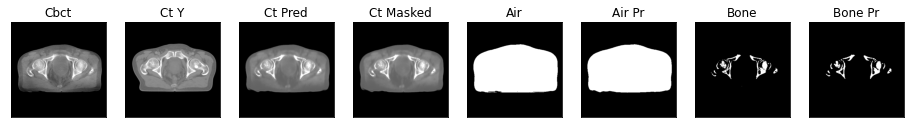

ssim score = 0.7801772356033325
psnr score = 20.42699432373047
snr score = 11.10844612121582
mae error = 0.039432600140571594
air dice score = 0.9957893283633639
bone dice score = 0.8887910798138382
contour dice score = 0.6303162574768066


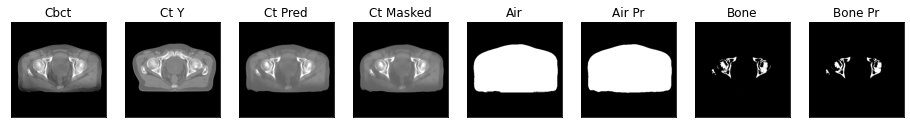

ssim score = 0.7961509227752686
psnr score = 20.96385955810547
snr score = 11.446149826049805
mae error = 0.035568106919527054
air dice score = 0.995879097194686
bone dice score = 0.9120724660329209
contour dice score = 0.6290322542190552


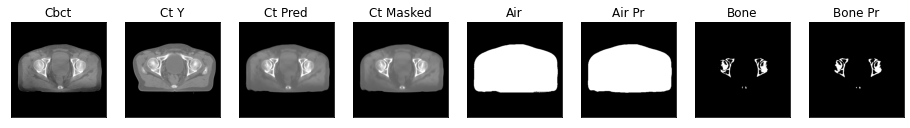

ssim score = 0.8125797510147095
psnr score = 21.644672393798828
snr score = 11.95656967163086
mae error = 0.0323006696999073
air dice score = 0.9956968518167929
bone dice score = 0.9410592255133676
contour dice score = 0.6045258641242981


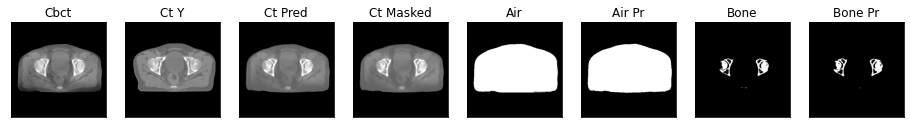

ssim score = 0.8194268941879272
psnr score = 21.989826202392578
snr score = 12.315892219543457
mae error = 0.03106570616364479
air dice score = 0.9953442025873217
bone dice score = 0.9447396386829869
contour dice score = 0.5896201133728027


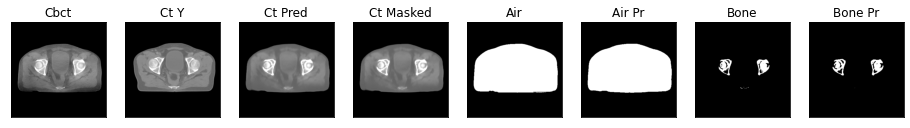

6it [00:23,  3.87s/it]

ssim score = 0.8243168592453003
psnr score = 22.17840576171875
snr score = 12.586298942565918
mae error = 0.030595974996685982
air dice score = 0.9945581267596009
bone dice score = 0.9476502878571743
contour dice score = 0.6254071593284607


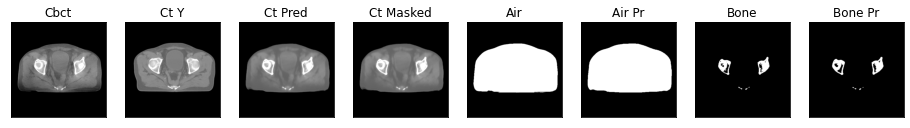

ssim score = 0.824640154838562
psnr score = 22.17920684814453
snr score = 12.67927360534668
mae error = 0.030461417511105537
air dice score = 0.9942047098502862
bone dice score = 0.938880484115902
contour dice score = 0.6354625821113586


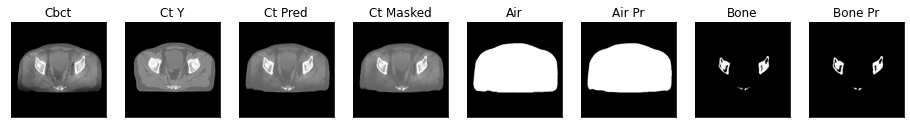

ssim score = 0.8227919340133667
psnr score = 22.43182373046875
snr score = 12.868462562561035
mae error = 0.02971259132027626
air dice score = 0.9954842887328782
bone dice score = 0.9550710274206298
contour dice score = 0.6383664608001709


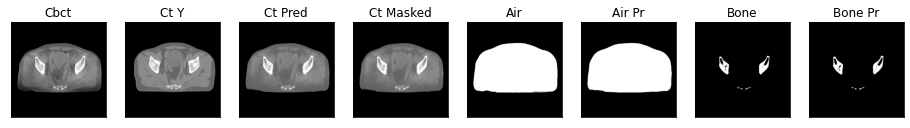

ssim score = 0.8259614706039429
psnr score = 22.639060974121094
snr score = 13.039304733276367
mae error = 0.02862095832824707
air dice score = 0.9951064246261776
bone dice score = 0.9475380483447173
contour dice score = 0.6115261316299438


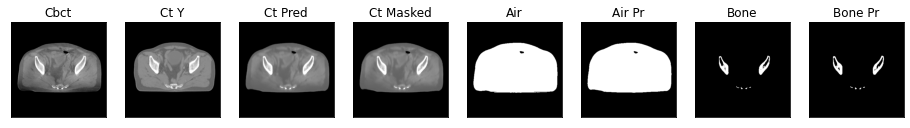

ssim score = 0.8200435042381287
psnr score = 22.35260772705078
snr score = 12.790597915649414
mae error = 0.0300886332988739
air dice score = 0.9956016844612738
bone dice score = 0.9209394641098091
contour dice score = 0.6206163763999939


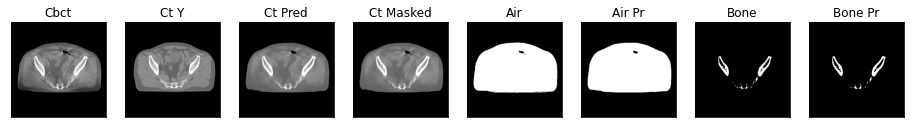

ssim score = 0.8150976300239563
psnr score = 22.199298858642578
snr score = 12.76779556274414
mae error = 0.031016528606414795
air dice score = 0.9959255195175305
bone dice score = 0.9268500141773909
contour dice score = 0.6146445870399475


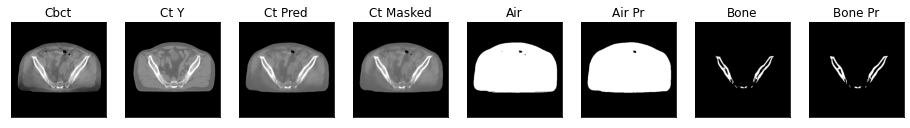

ssim score = 0.8167284727096558
psnr score = 22.14357566833496
snr score = 12.72982120513916
mae error = 0.031076528131961823
air dice score = 0.9964231750936919
bone dice score = 0.9019966468541076
contour dice score = 0.6563002467155457


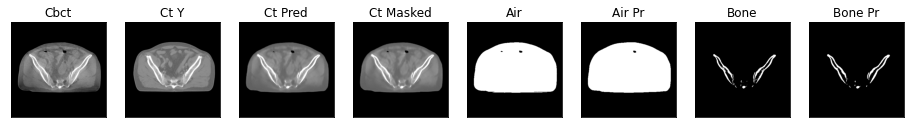

ssim score = 0.8189805150032043
psnr score = 22.55649185180664
snr score = 13.131465911865234
mae error = 0.029967958107590675
air dice score = 0.9966305139966591
bone dice score = 0.908882333662588
contour dice score = 0.6547812223434448


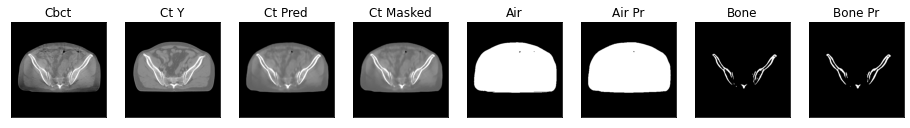

ssim score = 0.8212052583694458
psnr score = 22.634449005126953
snr score = 13.208683967590332
mae error = 0.02960355021059513
air dice score = 0.9965230562679687
bone dice score = 0.9060509554155087
contour dice score = 0.6379498243331909


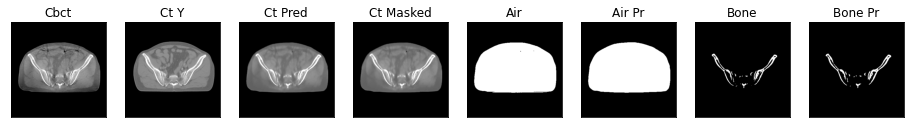

ssim score = 0.8762326240539551
psnr score = 24.292316436767578
snr score = 14.726451873779297
mae error = 0.0209118090569973
air dice score = 0.9973425838995613
bone dice score = 0.9477639984987687
contour dice score = 0.7409381866455078


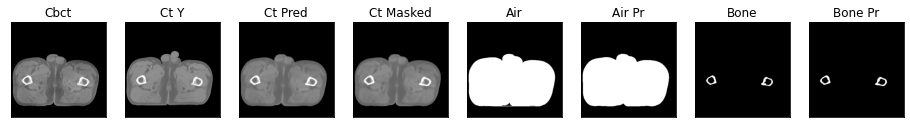

ssim score = 0.8743966221809387
psnr score = 24.42538833618164
snr score = 14.923913955688477
mae error = 0.020872360095381737
air dice score = 0.9971380231804333
bone dice score = 0.9309392265217217
contour dice score = 0.7052023410797119


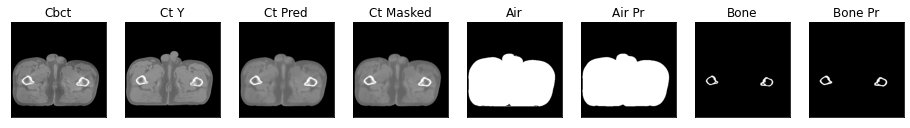

ssim score = 0.8790804743766785
psnr score = 25.63413429260254
snr score = 16.271873474121094
mae error = 0.020495928823947906
air dice score = 0.9976081416980649
bone dice score = 0.9405237461176094
contour dice score = 0.7445181012153625


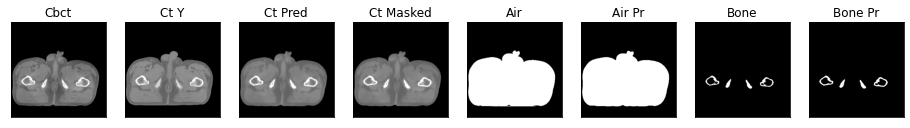

7it [00:26,  3.82s/it]

ssim score = 0.8802253007888794
psnr score = 25.5745849609375
snr score = 16.333812713623047
mae error = 0.02100132405757904
air dice score = 0.9982192153660732
bone dice score = 0.9217537235174794
contour dice score = 0.8055698871612549


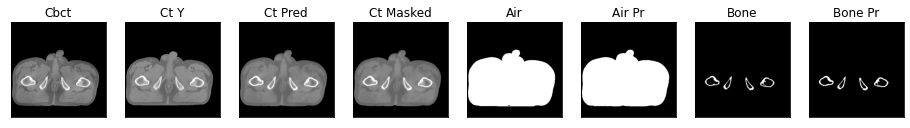

ssim score = 0.8761601448059082
psnr score = 25.39525032043457
snr score = 16.178653717041016
mae error = 0.021101223304867744
air dice score = 0.9982700706711053
bone dice score = 0.9062500000020345
contour dice score = 0.7935517430305481


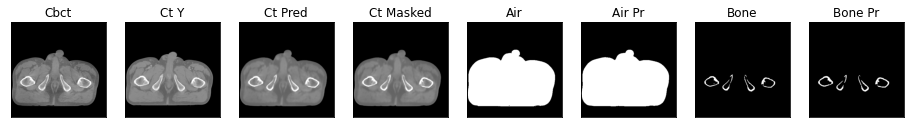

ssim score = 0.875991940498352
psnr score = 25.215065002441406
snr score = 15.994071960449219
mae error = 0.021139556542038918
air dice score = 0.9981565249721169
bone dice score = 0.9127941467290331
contour dice score = 0.8010444045066833


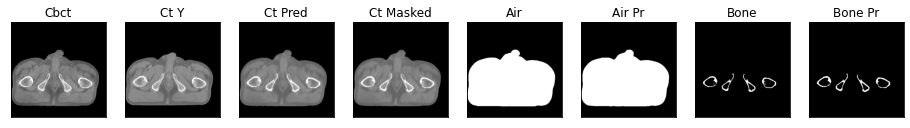

ssim score = 0.8768881559371948
psnr score = 24.78236198425293
snr score = 15.567625045776367
mae error = 0.02178991585969925
air dice score = 0.9979874603297484
bone dice score = 0.9175158623357524
contour dice score = 0.7413249015808105


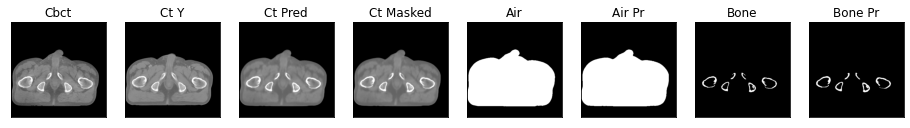

ssim score = 0.8756040334701538
psnr score = 24.560758590698242
snr score = 15.324464797973633
mae error = 0.0215457733720541
air dice score = 0.9980471777068302
bone dice score = 0.9147965005721796
contour dice score = 0.7519747018814087


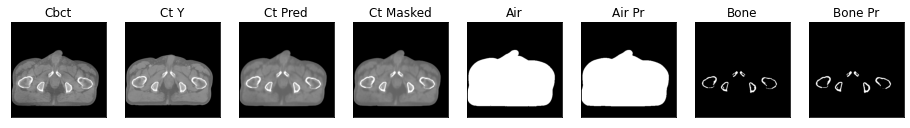

ssim score = 0.8762949109077454
psnr score = 24.59295654296875
snr score = 15.373574256896973
mae error = 0.021480264142155647
air dice score = 0.9979095268070175
bone dice score = 0.9256021409469116
contour dice score = 0.7333333492279053


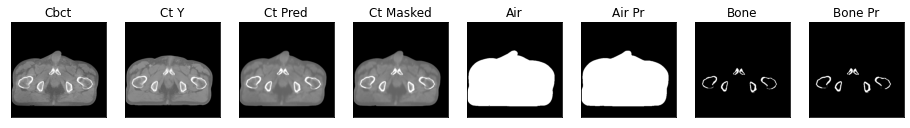

ssim score = 0.875873863697052
psnr score = 24.818920135498047
snr score = 15.668128967285156
mae error = 0.02129342220723629
air dice score = 0.9978231186361348
bone dice score = 0.9220295023517259
contour dice score = 0.7281450033187866


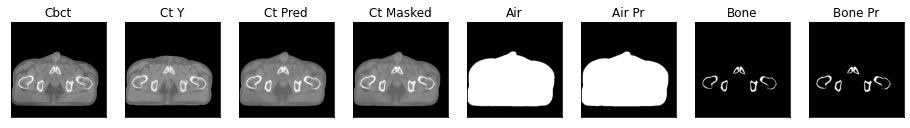

ssim score = 0.8756421804428101
psnr score = 25.098007202148438
snr score = 16.028573989868164
mae error = 0.021083394065499306
air dice score = 0.9978769908107404
bone dice score = 0.9176748303346463
contour dice score = 0.7391537427902222


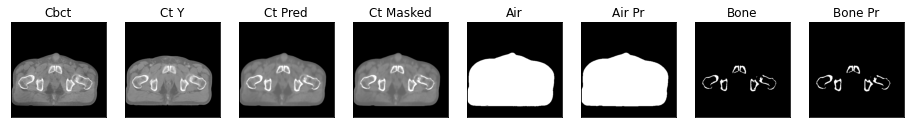

ssim score = 0.876282811164856
psnr score = 25.49280548095703
snr score = 16.474077224731445
mae error = 0.020746108144521713
air dice score = 0.9977666635211241
bone dice score = 0.9082098061586629
contour dice score = 0.7471819519996643


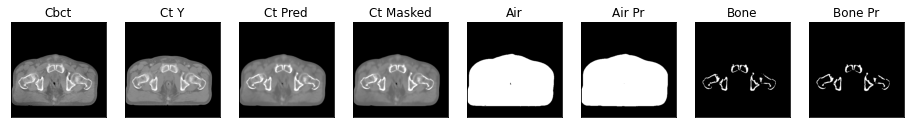

ssim score = 0.8778784275054932
psnr score = 25.830799102783203
snr score = 16.9283390045166
mae error = 0.02042531408369541
air dice score = 0.9983118501806492
bone dice score = 0.8940739758730734
contour dice score = 0.8019323945045471


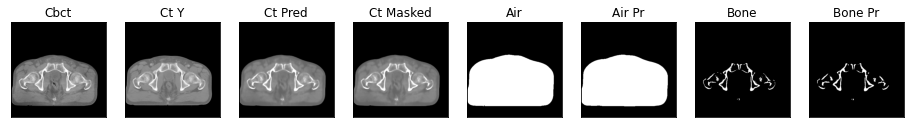

ssim score = 0.8767714500427246
psnr score = 25.59270668029785
snr score = 16.652009963989258
mae error = 0.020480720326304436
air dice score = 0.9982231811403384
bone dice score = 0.879954538998722
contour dice score = 0.7982786297798157


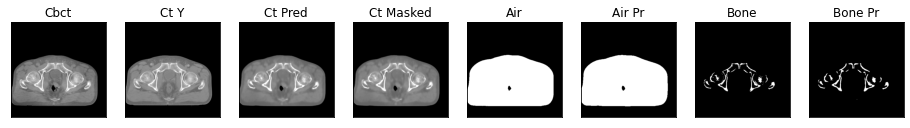

ssim score = 0.8700143694877625
psnr score = 24.81761932373047
snr score = 15.781251907348633
mae error = 0.021710969507694244
air dice score = 0.9980570724959837
bone dice score = 0.8800313643507576
contour dice score = 0.8314485549926758


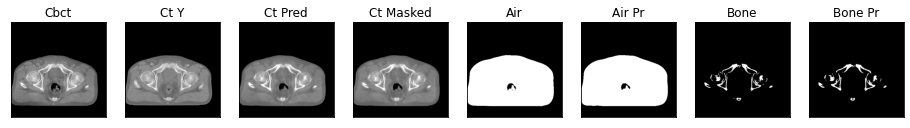

8it [00:30,  3.78s/it]

ssim score = 0.8748422265052795
psnr score = 24.75996971130371
snr score = 15.5638427734375
mae error = 0.021326446905732155
air dice score = 0.9975607988987389
bone dice score = 0.8852621167180141
contour dice score = 0.8054053783416748


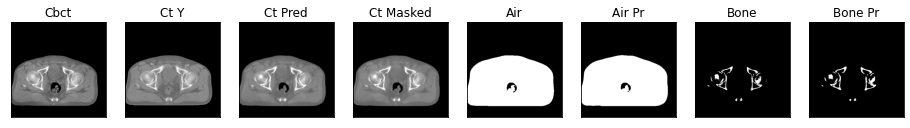

ssim score = 0.8730127215385437
psnr score = 24.427146911621094
snr score = 15.114598274230957
mae error = 0.021464545279741287
air dice score = 0.9975018512340225
bone dice score = 0.8839285714305644
contour dice score = 0.8136511445045471


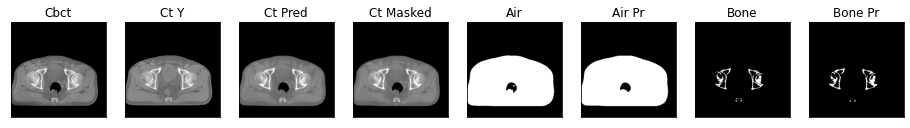

ssim score = 0.868456244468689
psnr score = 24.368553161621094
snr score = 15.010909080505371
mae error = 0.021474365144968033
air dice score = 0.9979283520982617
bone dice score = 0.9111040809884355
contour dice score = 0.809135377407074


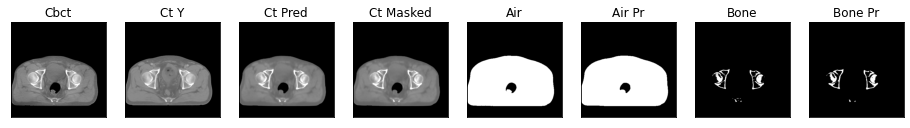

ssim score = 0.8617662787437439
psnr score = 23.76392364501953
snr score = 14.412954330444336
mae error = 0.023214638233184814
air dice score = 0.9979741976756601
bone dice score = 0.9318181818192579
contour dice score = 0.798255205154419


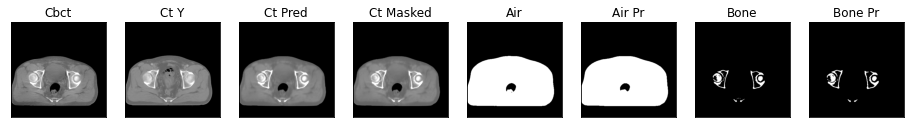

ssim score = 0.8641396164894104
psnr score = 23.454133987426758
snr score = 14.13326644897461
mae error = 0.023914571851491928
air dice score = 0.9977814297452771
bone dice score = 0.939961646261396
contour dice score = 0.7672131061553955


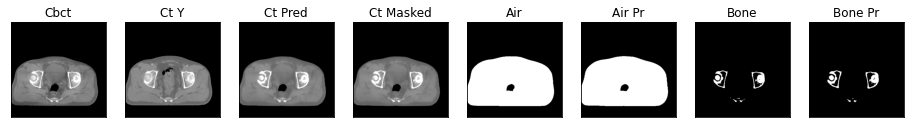

ssim score = 0.8717582821846008
psnr score = 24.188072204589844
snr score = 14.82461929321289
mae error = 0.022419817745685577
air dice score = 0.9975794871794892
bone dice score = 0.932912653604568
contour dice score = 0.7580556869506836


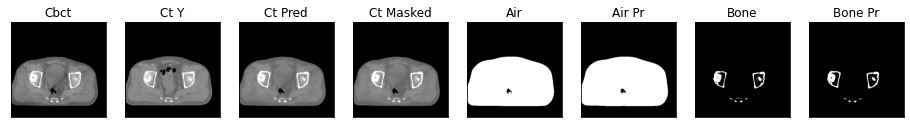

ssim score = 0.8738511800765991
psnr score = 24.533283233642578
snr score = 15.079626083374023
mae error = 0.020920762792229652
air dice score = 0.9977262242140663
bone dice score = 0.9202453987744889
contour dice score = 0.745076596736908


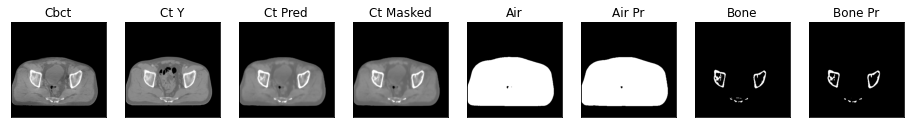

ssim score = 0.8747623562812805
psnr score = 24.189476013183594
snr score = 14.67009162902832
mae error = 0.021152684465050697
air dice score = 0.9974030730302497
bone dice score = 0.9258757499530506
contour dice score = 0.7268746495246887


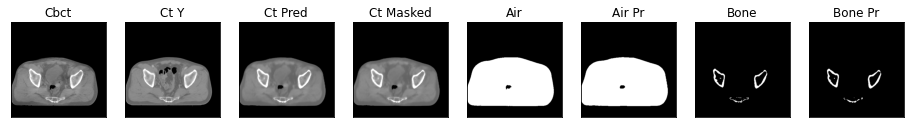

ssim score = 0.8722894191741943
psnr score = 24.20505142211914
snr score = 14.68536376953125
mae error = 0.021298089995980263
air dice score = 0.9971646673936774
bone dice score = 0.9244610422691485
contour dice score = 0.7245739698410034


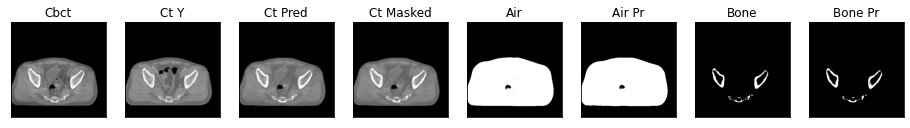

ssim score = 0.8646894097328186
psnr score = 24.058664321899414
snr score = 14.615143775939941
mae error = 0.022610526531934738
air dice score = 0.9966807227895504
bone dice score = 0.9248266296820412
contour dice score = 0.695364236831665


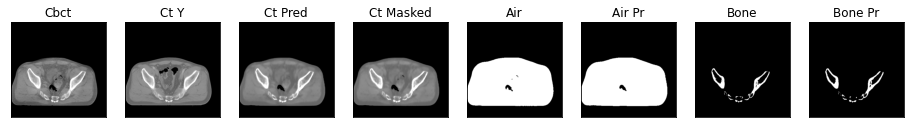

ssim score = 0.8704978227615356
psnr score = 24.31265640258789
snr score = 14.904716491699219
mae error = 0.02194794826209545
air dice score = 0.9962669394016908
bone dice score = 0.9202674897129596
contour dice score = 0.6567493081092834


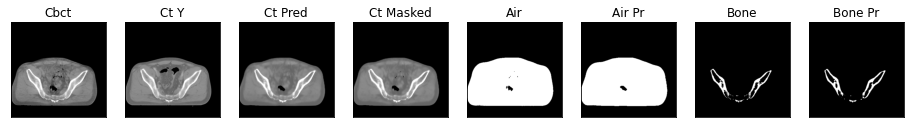

ssim score = 0.8734822273254395
psnr score = 24.931690216064453
snr score = 15.462053298950195
mae error = 0.020678328350186348
air dice score = 0.9968635919584581
bone dice score = 0.9024125779357223
contour dice score = 0.7184035181999207


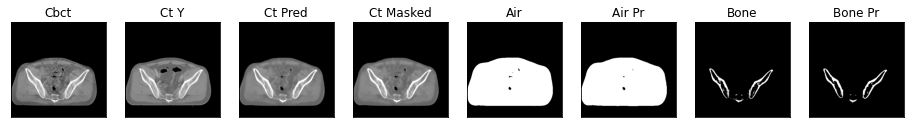

9it [00:34,  3.76s/it]

ssim score = 0.8699449896812439
psnr score = 24.650495529174805
snr score = 15.119598388671875
mae error = 0.021210430189967155
air dice score = 0.9966482956410595
bone dice score = 0.902861976598014
contour dice score = 0.6905428171157837


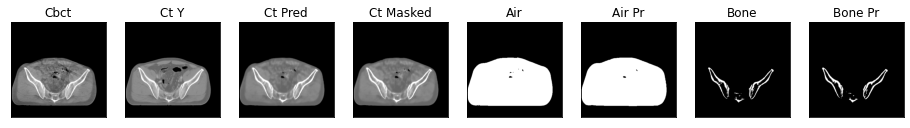

ssim score = 0.8135791420936584
psnr score = 22.092967987060547
snr score = 13.79027271270752
mae error = 0.03121977113187313
air dice score = 0.9979361202609135
bone dice score = 0.9680620155048663
contour dice score = 0.766313910484314


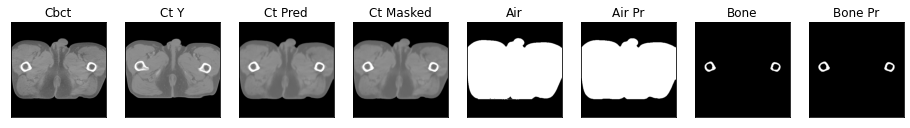

ssim score = 0.8045370578765869
psnr score = 21.72727394104004
snr score = 13.528870582580566
mae error = 0.03260890394449234
air dice score = 0.9978895884403541
bone dice score = 0.9631901840501063
contour dice score = 0.7394585013389587


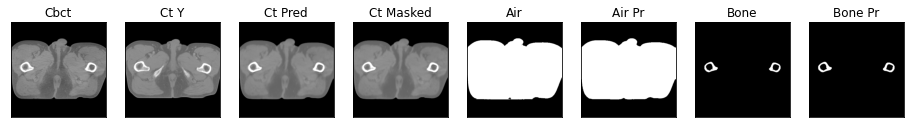

ssim score = 0.7968249320983887
psnr score = 21.406858444213867
snr score = 13.33641242980957
mae error = 0.034649066627025604
air dice score = 0.9980143970854407
bone dice score = 0.9391226499565998
contour dice score = 0.7520071268081665


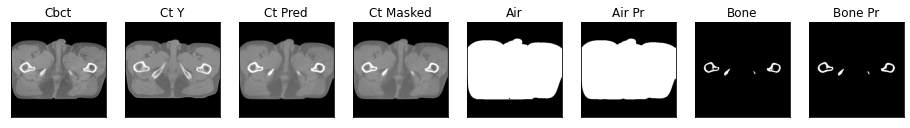

ssim score = 0.7888502478599548
psnr score = 20.95623779296875
snr score = 12.918081283569336
mae error = 0.0359870083630085
air dice score = 0.998194935303912
bone dice score = 0.9463589076731737
contour dice score = 0.7786738276481628


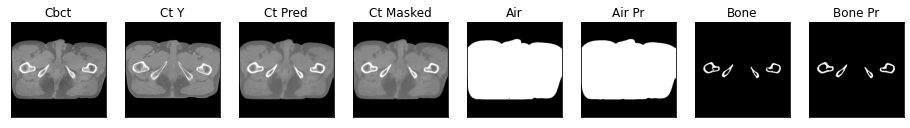

ssim score = 0.7808062434196472
psnr score = 20.845632553100586
snr score = 12.837714195251465
mae error = 0.03678891435265541
air dice score = 0.998123871118104
bone dice score = 0.9201197416114681
contour dice score = 0.7632763385772705


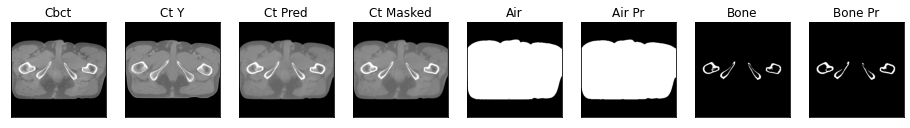

ssim score = 0.7726903557777405
psnr score = 20.740516662597656
snr score = 12.767011642456055
mae error = 0.03795398026704788
air dice score = 0.9982164124909233
bone dice score = 0.9207817395207999
contour dice score = 0.7612612843513489


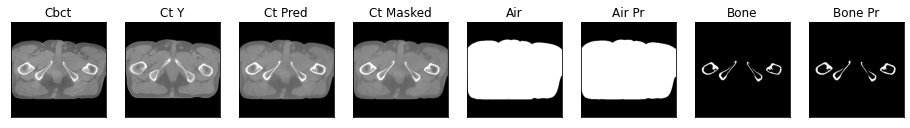

ssim score = 0.7650741338729858
psnr score = 20.41158676147461
snr score = 12.458395957946777
mae error = 0.03943828120827675
air dice score = 0.9982171179827973
bone dice score = 0.9288736118465247
contour dice score = 0.7678491473197937


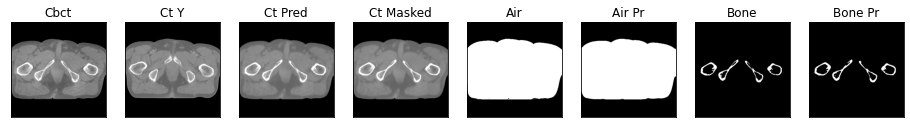

ssim score = 0.7625016570091248
psnr score = 20.441722869873047
snr score = 12.527605056762695
mae error = 0.038881756365299225
air dice score = 0.9974801766188146
bone dice score = 0.9389732844429155
contour dice score = 0.7283288836479187


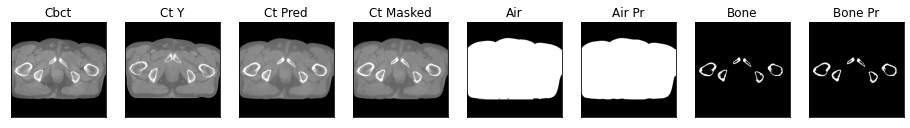

ssim score = 0.7610384821891785
psnr score = 20.542911529541016
snr score = 12.677474021911621
mae error = 0.03859202563762665
air dice score = 0.9966930681621109
bone dice score = 0.9387703572788945
contour dice score = 0.6923409700393677


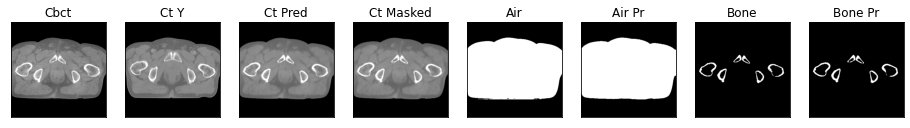

ssim score = 0.7543461918830872
psnr score = 20.349016189575195
snr score = 12.50618839263916
mae error = 0.04052450507879257
air dice score = 0.9967996117940678
bone dice score = 0.934227866300057
contour dice score = 0.6914938688278198


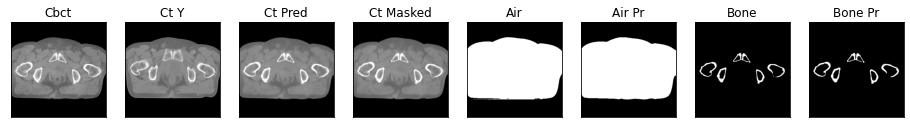

ssim score = 0.742705762386322
psnr score = 20.26992416381836
snr score = 12.469873428344727
mae error = 0.04228540137410164
air dice score = 0.9973831948078912
bone dice score = 0.9275557048490924
contour dice score = 0.7344345450401306


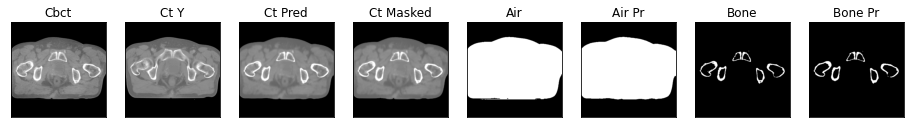

10it [00:38,  3.75s/it]

ssim score = 0.7407312989234924
psnr score = 20.220191955566406
snr score = 12.478479385375977
mae error = 0.043089743703603745
air dice score = 0.9977538159278017
bone dice score = 0.9305043050437628
contour dice score = 0.7459312677383423


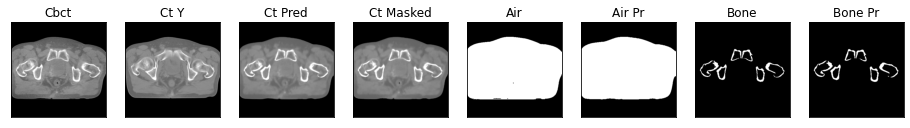

ssim score = 0.7331820726394653
psnr score = 19.941537857055664
snr score = 12.124454498291016
mae error = 0.04487181454896927
air dice score = 0.9983986592358343
bone dice score = 0.9233641370304922
contour dice score = 0.8105406761169434


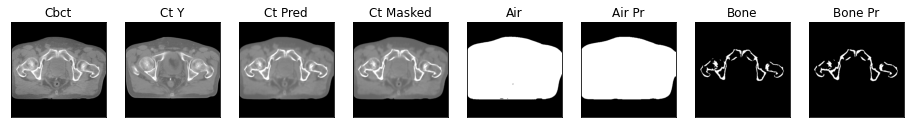

ssim score = 0.7371765971183777
psnr score = 19.87427520751953
snr score = 11.949974060058594
mae error = 0.04517786204814911
air dice score = 0.9984046643482661
bone dice score = 0.9103221083463551
contour dice score = 0.7903592586517334


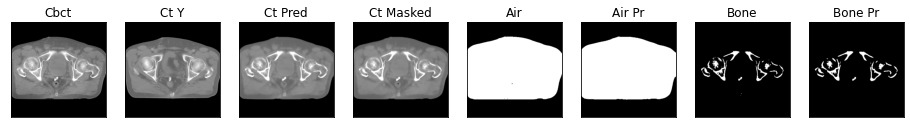

ssim score = 0.7495290040969849
psnr score = 20.120515823364258
snr score = 12.073126792907715
mae error = 0.0442718006670475
air dice score = 0.9984375538526944
bone dice score = 0.8801652892573237
contour dice score = 0.7959835529327393


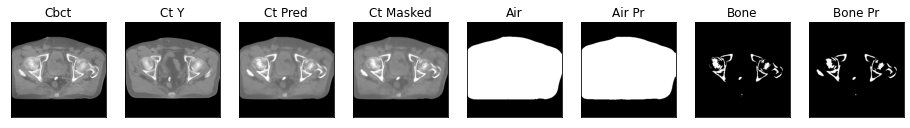

ssim score = 0.758006751537323
psnr score = 20.361316680908203
snr score = 12.201496124267578
mae error = 0.042685601860284805
air dice score = 0.9985952953909577
bone dice score = 0.8971981057626559
contour dice score = 0.8089990615844727


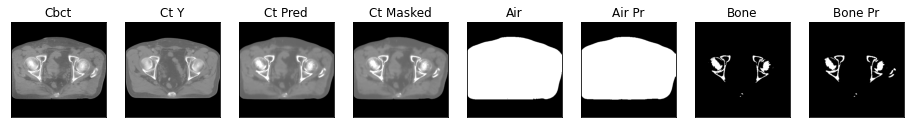

ssim score = 0.7540216445922852
psnr score = 20.615642547607422
snr score = 12.40517520904541
mae error = 0.04030807688832283
air dice score = 0.9985337751249763
bone dice score = 0.927976190476905
contour dice score = 0.8046082854270935


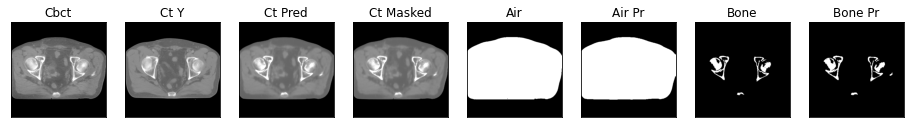

ssim score = 0.7518894076347351
psnr score = 20.484830856323242
snr score = 12.306522369384766
mae error = 0.04143376275897026
air dice score = 0.998511413462152
bone dice score = 0.9322878033280462
contour dice score = 0.8153632283210754


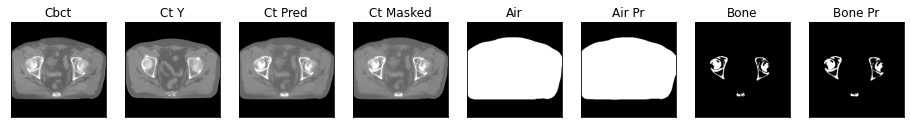

ssim score = 0.7518452405929565
psnr score = 20.37610626220703
snr score = 12.211273193359375
mae error = 0.04192252829670906
air dice score = 0.9983602363120445
bone dice score = 0.9330722267027637
contour dice score = 0.7837713360786438


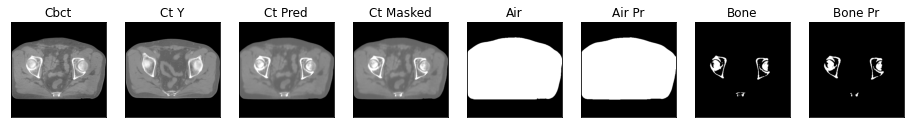

ssim score = 0.7494730353355408
psnr score = 19.885189056396484
snr score = 11.578864097595215
mae error = 0.04430872201919556
air dice score = 0.9980776085216295
bone dice score = 0.9377373690880683
contour dice score = 0.7488284707069397


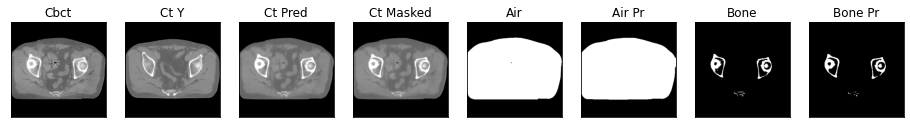

ssim score = 0.760051965713501
psnr score = 20.055131912231445
snr score = 11.689498901367188
mae error = 0.04316002130508423
air dice score = 0.9985545736579872
bone dice score = 0.9395262670379843
contour dice score = 0.7916863560676575


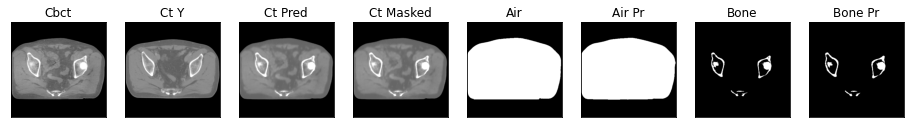

ssim score = 0.7594560980796814
psnr score = 20.47267723083496
snr score = 12.1326904296875
mae error = 0.04043139889836311
air dice score = 0.9984114892435981
bone dice score = 0.9031437397800628
contour dice score = 0.7690127491950989


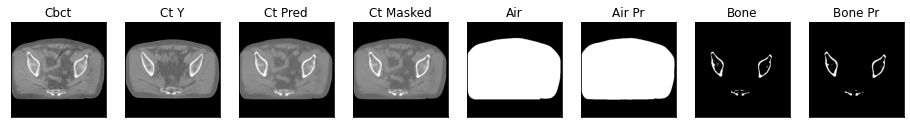

ssim score = 0.7541770935058594
psnr score = 20.420228958129883
snr score = 12.153057098388672
mae error = 0.04078271612524986
air dice score = 0.9980540360952584
bone dice score = 0.9234172906752312
contour dice score = 0.7315689921379089


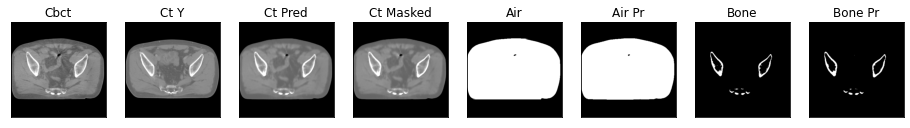

11it [00:41,  3.74s/it]

ssim score = 0.7454172372817993
psnr score = 20.07908058166504
snr score = 11.941137313842773
mae error = 0.04270793870091438
air dice score = 0.9976180099936136
bone dice score = 0.9242687747047547
contour dice score = 0.6707897186279297


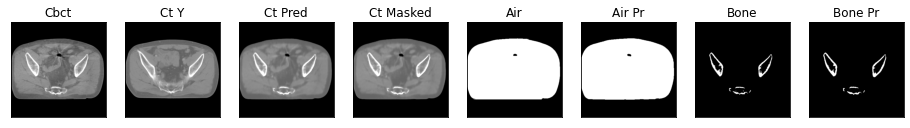

ssim score = 0.7388371825218201
psnr score = 19.92234992980957
snr score = 11.818367004394531
mae error = 0.04360457882285118
air dice score = 0.9975739524158405
bone dice score = 0.9242533544953938
contour dice score = 0.6867815852165222


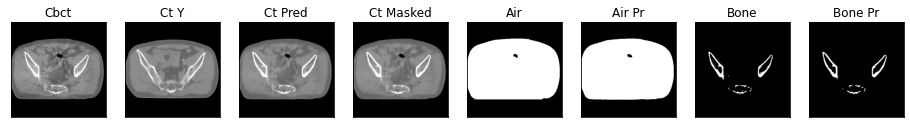

ssim score = 0.7286322712898254
psnr score = 19.785295486450195
snr score = 11.651521682739258
mae error = 0.04492931440472603
air dice score = 0.99791634046756
bone dice score = 0.9204981957872133
contour dice score = 0.7076331973075867


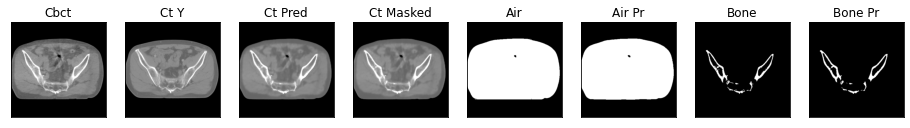

ssim score = 0.7283673286437988
psnr score = 20.0032901763916
snr score = 11.806142807006836
mae error = 0.04360445961356163
air dice score = 0.9977761663040864
bone dice score = 0.8964417177926817
contour dice score = 0.6795180439949036


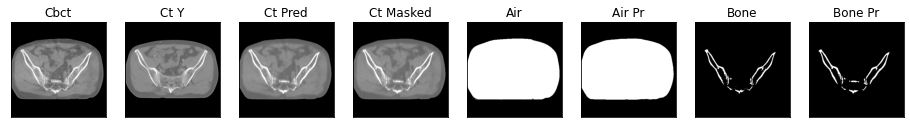

ssim score = 0.8568811416625977
psnr score = 23.957015991210938
snr score = 15.434408187866211
mae error = 0.026806559413671494
air dice score = 0.9979928453454024
bone dice score = 0.909155012340943
contour dice score = 0.8031967878341675


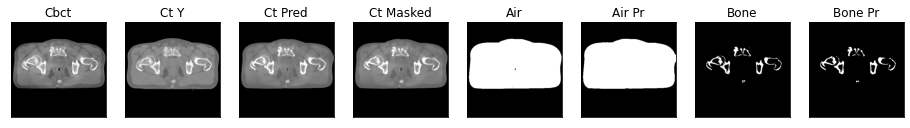

ssim score = 0.8608923554420471
psnr score = 24.40284538269043
snr score = 15.920247077941895
mae error = 0.025141239166259766
air dice score = 0.9981447124304281
bone dice score = 0.9022869022880973
contour dice score = 0.8144433498382568


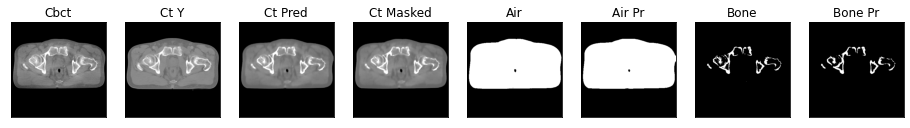

ssim score = 0.8612087368965149
psnr score = 24.626049041748047
snr score = 16.1512393951416
mae error = 0.02521565742790699
air dice score = 0.9983137345209013
bone dice score = 0.8870495352109123
contour dice score = 0.8304914832115173


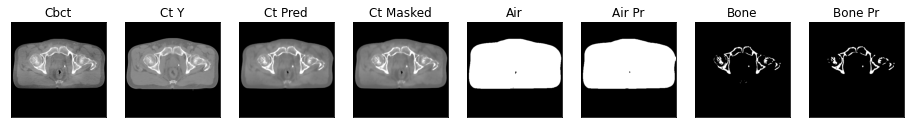

ssim score = 0.8643471598625183
psnr score = 24.553068161010742
snr score = 16.019838333129883
mae error = 0.024631768465042114
air dice score = 0.9985608506640231
bone dice score = 0.8952585692118086
contour dice score = 0.8312214612960815


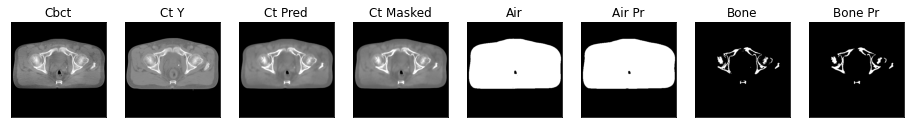

ssim score = 0.8724769949913025
psnr score = 24.913002014160156
snr score = 16.22414779663086
mae error = 0.022420311346650124
air dice score = 0.998683974397321
bone dice score = 0.8819875776414562
contour dice score = 0.8553971648216248


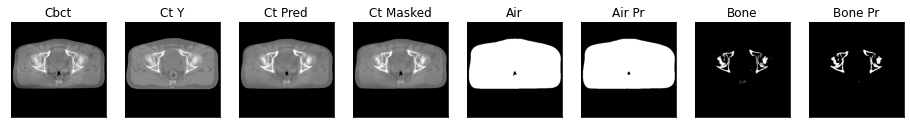

ssim score = 0.8751034140586853
psnr score = 25.05788803100586
snr score = 16.348230361938477
mae error = 0.02210496924817562
air dice score = 0.9984479151826898
bone dice score = 0.9066412629299586
contour dice score = 0.8196218609809875


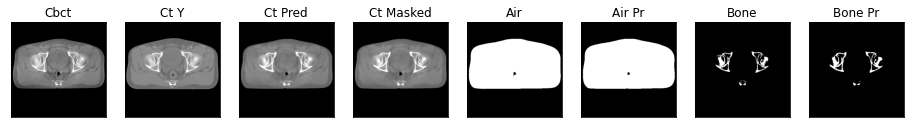

ssim score = 0.8738661408424377
psnr score = 25.07906150817871
snr score = 16.353775024414062
mae error = 0.022223250940442085
air dice score = 0.998390832255543
bone dice score = 0.9139712790241046
contour dice score = 0.8297435641288757


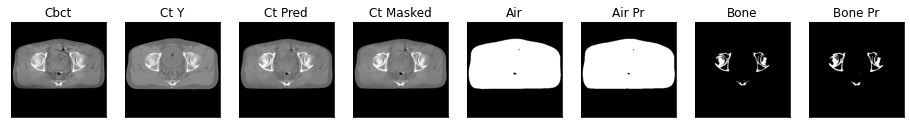

ssim score = 0.8666881918907166
psnr score = 24.333036422729492
snr score = 15.617114067077637
mae error = 0.02358296513557434
air dice score = 0.9976137976862917
bone dice score = 0.9194094541525205
contour dice score = 0.7475578188896179


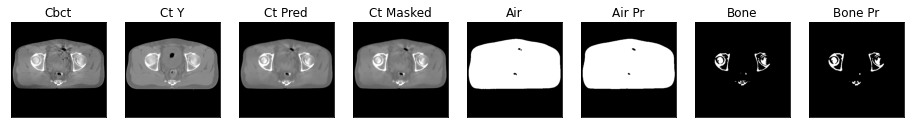

12it [00:45,  3.71s/it]

ssim score = 0.8642298579216003
psnr score = 24.549564361572266
snr score = 15.889423370361328
mae error = 0.023812109604477882
air dice score = 0.9980868263246663
bone dice score = 0.9349993353723913
contour dice score = 0.8002064824104309


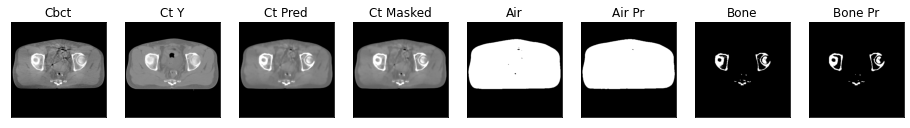

ssim score = 0.8625344038009644
psnr score = 23.85077476501465
snr score = 15.16870403289795
mae error = 0.024884207174181938
air dice score = 0.9980699968086576
bone dice score = 0.926178153092806
contour dice score = 0.8344576954841614


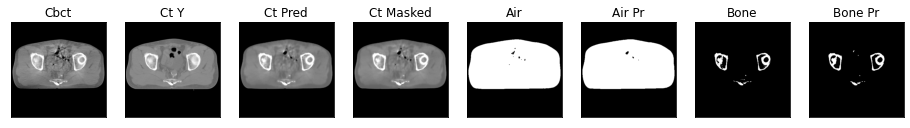

ssim score = 0.8630447387695312
psnr score = 23.169565200805664
snr score = 14.41672134399414
mae error = 0.02529417909681797
air dice score = 0.9981997375888703
bone dice score = 0.9092007856185345
contour dice score = 0.8623566031455994


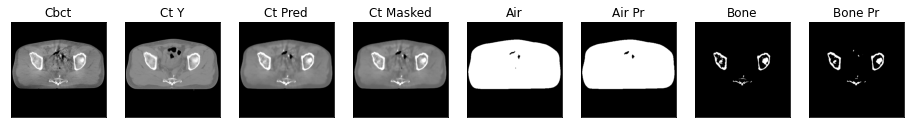

ssim score = 0.8644315600395203
psnr score = 23.672134399414062
snr score = 14.875396728515625
mae error = 0.02424897626042366
air dice score = 0.9982448911069409
bone dice score = 0.9150535914267308
contour dice score = 0.8587865829467773


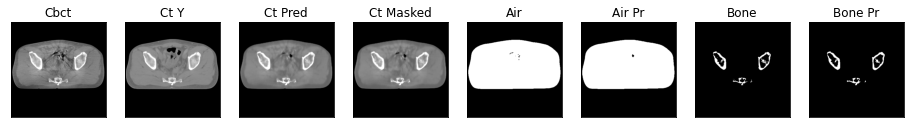

ssim score = 0.8670506477355957
psnr score = 24.013587951660156
snr score = 15.215753555297852
mae error = 0.02349282242357731
air dice score = 0.9979324920362672
bone dice score = 0.9216648203842117
contour dice score = 0.8060956597328186


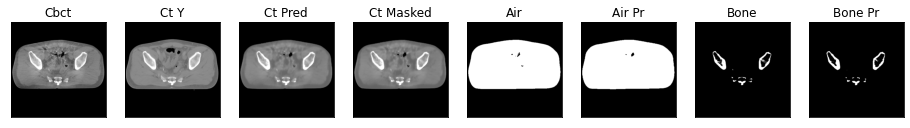

ssim score = 0.8618921041488647
psnr score = 24.229522705078125
snr score = 15.445043563842773
mae error = 0.023427549749612808
air dice score = 0.9972712668239873
bone dice score = 0.926616541354487
contour dice score = 0.7894737124443054


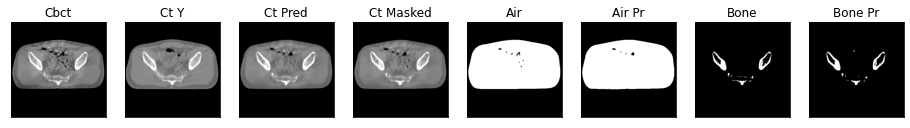

ssim score = 0.8589783310890198
psnr score = 23.999343872070312
snr score = 15.270069122314453
mae error = 0.02411656454205513
air dice score = 0.9973504306515798
bone dice score = 0.9283932135737476
contour dice score = 0.78205806016922


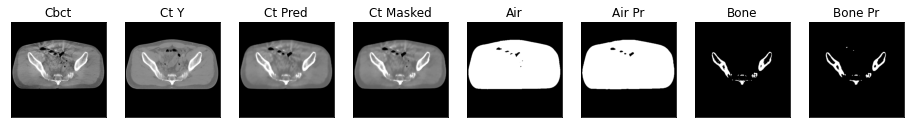

ssim score = 0.8586575984954834
psnr score = 23.27325439453125
snr score = 14.563350677490234
mae error = 0.025263451039791107
air dice score = 0.9970195009793091
bone dice score = 0.9197696737054412
contour dice score = 0.7540983557701111


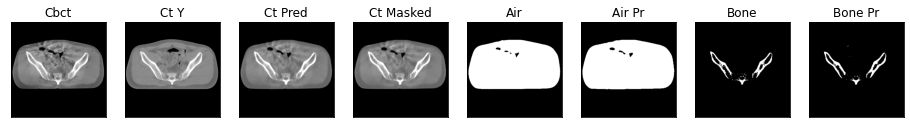

ssim score = 0.864010751247406
psnr score = 23.39952278137207
snr score = 14.634878158569336
mae error = 0.02425852045416832
air dice score = 0.997006705906924
bone dice score = 0.9083587892264876
contour dice score = 0.7076271176338196


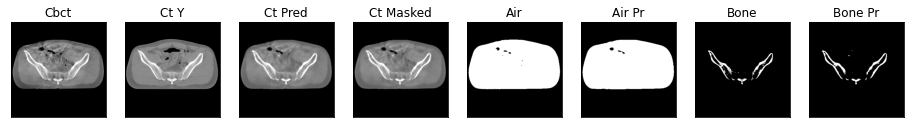

ssim score = 0.8643470406532288
psnr score = 23.61639404296875
snr score = 14.815399169921875
mae error = 0.024066252633929253
air dice score = 0.997419015825917
bone dice score = 0.8995873452558516
contour dice score = 0.7348242998123169


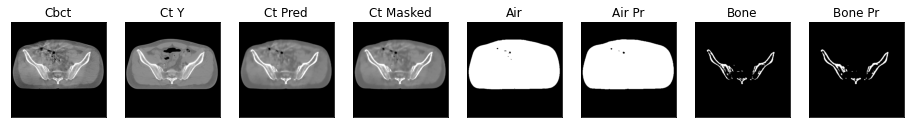

ssim score = 0.8669748902320862
psnr score = 23.747663497924805
snr score = 14.946741104125977
mae error = 0.023722538724541664
air dice score = 0.997557015848475
bone dice score = 0.8972008917525737
contour dice score = 0.7681623697280884


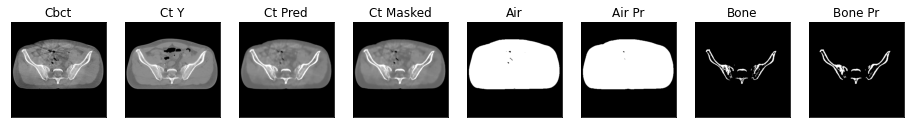

ssim score = 0.8636530637741089
psnr score = 24.004886627197266
snr score = 15.202542304992676
mae error = 0.023527931421995163
air dice score = 0.9977147903416987
bone dice score = 0.8949532710293464
contour dice score = 0.7694787979125977


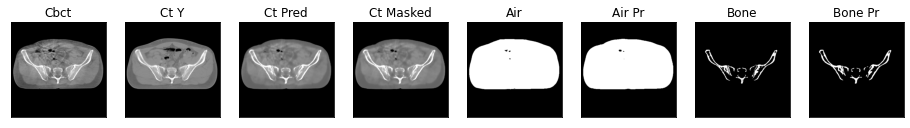

13it [00:49,  3.70s/it]

ssim score = 0.85451340675354
psnr score = 23.337234497070312
snr score = 14.539926528930664
mae error = 0.025188082829117775
air dice score = 0.9971000971817321
bone dice score = 0.8928971265096045
contour dice score = 0.7470270395278931


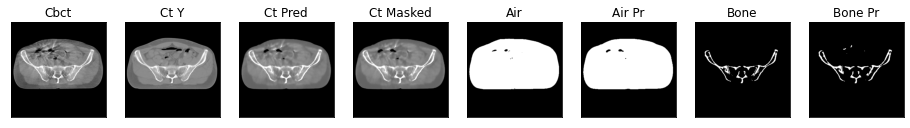

ssim score = 0.8463329672813416
psnr score = 22.69748878479004
snr score = 13.882908821105957
mae error = 0.026700211688876152
air dice score = 0.9961557093966369
bone dice score = 0.8924034869253747
contour dice score = 0.7438825368881226


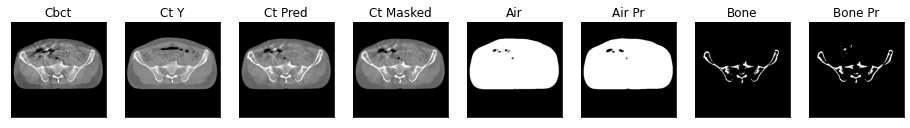

ssim score = 0.8399080634117126
psnr score = 22.22871971130371
snr score = 13.39551830291748
mae error = 0.028113259002566338
air dice score = 0.9962579724015688
bone dice score = 0.893322380003599
contour dice score = 0.7287670969963074


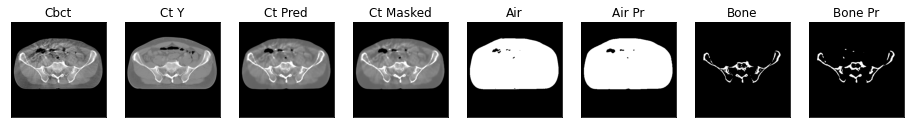

ssim score = 0.831041157245636
psnr score = 21.824464797973633
snr score = 12.94532299041748
mae error = 0.02948766015470028
air dice score = 0.9961893364406543
bone dice score = 0.8946829101685678
contour dice score = 0.7471074461936951


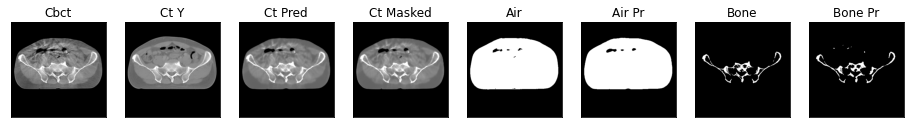

ssim score = 0.8232681155204773
psnr score = 21.77915382385254
snr score = 12.846214294433594
mae error = 0.030060622841119766
air dice score = 0.996031934234451
bone dice score = 0.9020859455157632
contour dice score = 0.7549889087677002


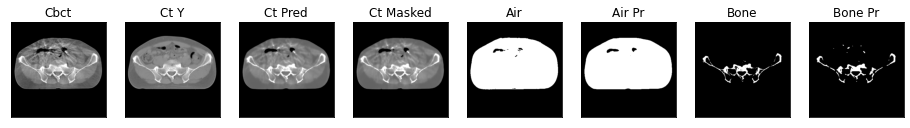

ssim score = 0.8156700134277344
psnr score = 21.37281036376953
snr score = 12.470331192016602
mae error = 0.031841907650232315
air dice score = 0.9960304228393623
bone dice score = 0.9136023248025751
contour dice score = 0.7526403665542603


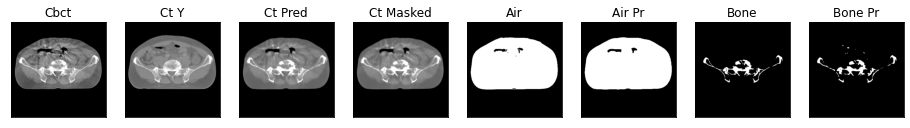

ssim score = 0.8098974227905273
psnr score = 21.116933822631836
snr score = 12.159232139587402
mae error = 0.03202318027615547
air dice score = 0.996094837390941
bone dice score = 0.9084745762722561
contour dice score = 0.7307051420211792


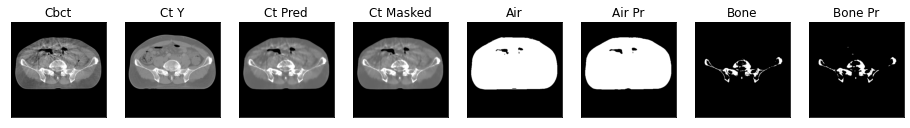

ssim score = 0.8204624652862549
psnr score = 21.826961517333984
snr score = 12.72172737121582
mae error = 0.02926808036863804
air dice score = 0.9965288282406919
bone dice score = 0.9188790560481948
contour dice score = 0.6893095970153809


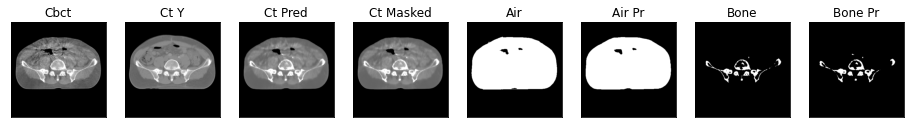

ssim score = 0.8874046802520752
psnr score = 26.624784469604492
snr score = 17.005695343017578
mae error = 0.016437269747257233
air dice score = 0.995718149592085
bone dice score = 0.9436170212780953
contour dice score = 0.6327519416809082


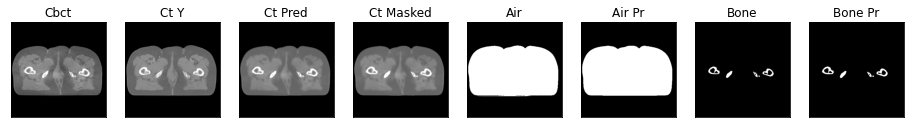

ssim score = 0.8870612978935242
psnr score = 26.80449676513672
snr score = 17.306421279907227
mae error = 0.016417857259511948
air dice score = 0.9961993892660236
bone dice score = 0.9359803702891818
contour dice score = 0.6666666865348816


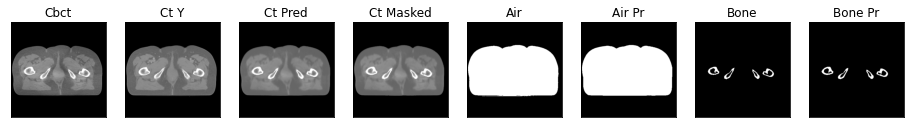

ssim score = 0.8830733299255371
psnr score = 26.60633087158203
snr score = 17.19116973876953
mae error = 0.01710827834904194
air dice score = 0.9960781460326729
bone dice score = 0.9271065989862517
contour dice score = 0.6442167162895203


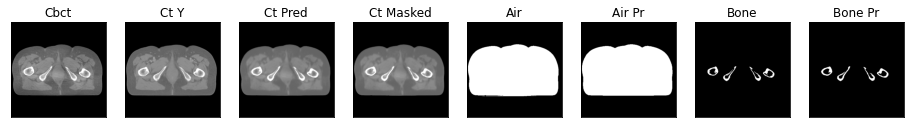

ssim score = 0.8808584809303284
psnr score = 26.463211059570312
snr score = 17.11149787902832
mae error = 0.017586471512913704
air dice score = 0.9960384996994502
bone dice score = 0.9274208144809517
contour dice score = 0.6338371634483337


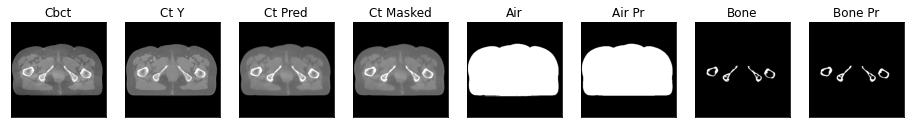

14it [00:52,  3.68s/it]

ssim score = 0.8804248571395874
psnr score = 26.335344314575195
snr score = 17.01209259033203
mae error = 0.01777040585875511
air dice score = 0.99629068340911
bone dice score = 0.9324535509648818
contour dice score = 0.6476658582687378


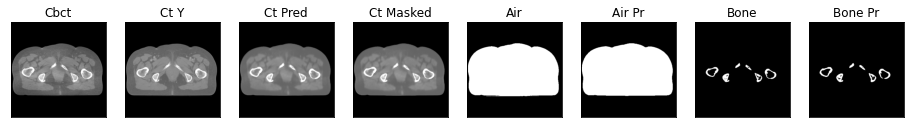

ssim score = 0.8808879852294922
psnr score = 26.305543899536133
snr score = 17.0052490234375
mae error = 0.017561456188559532
air dice score = 0.9961632870480372
bone dice score = 0.9290068124788633
contour dice score = 0.6627793908119202


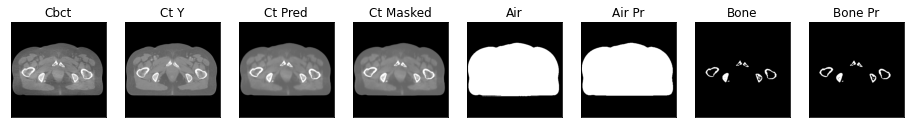

ssim score = 0.876410961151123
psnr score = 26.14600944519043
snr score = 16.877038955688477
mae error = 0.017935242503881454
air dice score = 0.9961216369564933
bone dice score = 0.9162823696361071
contour dice score = 0.6454106569290161


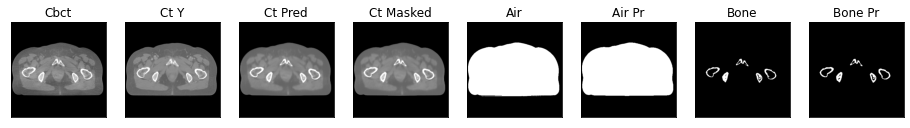

ssim score = 0.8749449253082275
psnr score = 26.03180694580078
snr score = 16.811201095581055
mae error = 0.01851993054151535
air dice score = 0.9959699972750901
bone dice score = 0.9186306554288899
contour dice score = 0.6106153130531311


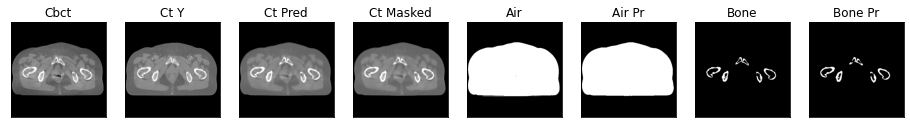

ssim score = 0.8754301071166992
psnr score = 25.72360610961914
snr score = 16.545743942260742
mae error = 0.018723376095294952
air dice score = 0.9958315097683325
bone dice score = 0.9191774270696768
contour dice score = 0.624099850654602


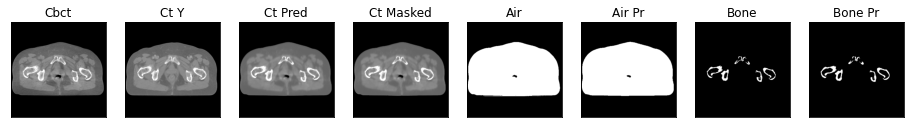

ssim score = 0.8716714382171631
psnr score = 25.464157104492188
snr score = 16.373998641967773
mae error = 0.0196295827627182
air dice score = 0.9952159287338384
bone dice score = 0.9178462392462137
contour dice score = 0.5825965404510498


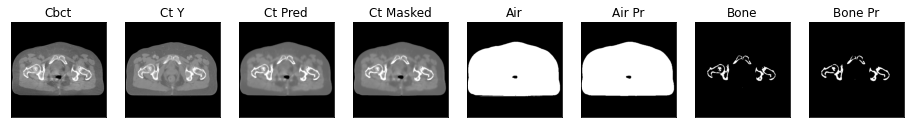

ssim score = 0.8757174015045166
psnr score = 26.39585304260254
snr score = 17.418964385986328
mae error = 0.019029129296541214
air dice score = 0.9948037116345505
bone dice score = 0.9213509137182355
contour dice score = 0.5552486181259155


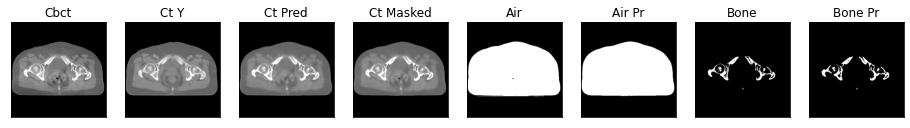

ssim score = 0.8803898692131042
psnr score = 25.948509216308594
snr score = 16.843069076538086
mae error = 0.01846059411764145
air dice score = 0.9947130071471024
bone dice score = 0.896047824644702
contour dice score = 0.555913507938385


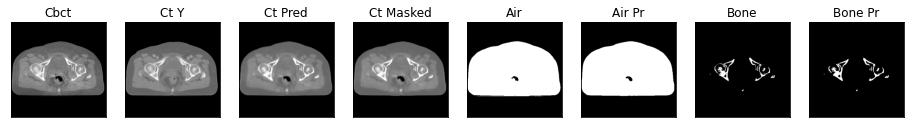

ssim score = 0.8822570443153381
psnr score = 26.114015579223633
snr score = 16.899154663085938
mae error = 0.017868662253022194
air dice score = 0.9948907769591941
bone dice score = 0.8880540946677675
contour dice score = 0.5643656849861145


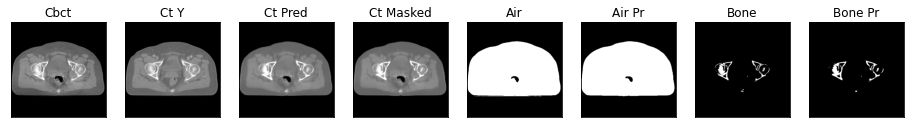

ssim score = 0.8854469656944275
psnr score = 26.12322998046875
snr score = 16.881240844726562
mae error = 0.018200745806097984
air dice score = 0.9951049200185292
bone dice score = 0.9122098890024856
contour dice score = 0.5599268078804016


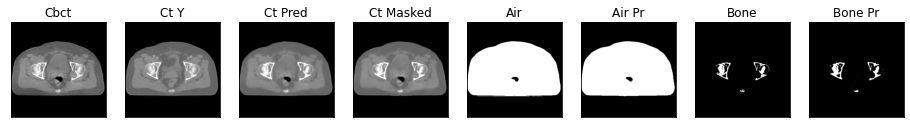

ssim score = 0.8881571888923645
psnr score = 26.803829193115234
snr score = 17.5538387298584
mae error = 0.018022729083895683
air dice score = 0.995633743111491
bone dice score = 0.918463284164071
contour dice score = 0.6020503044128418


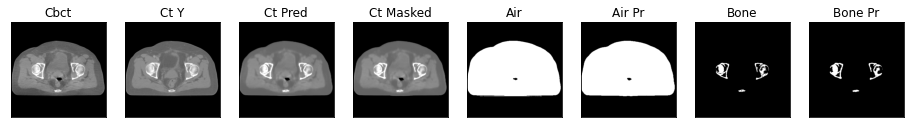

ssim score = 0.8865556716918945
psnr score = 27.474796295166016
snr score = 18.259033203125
mae error = 0.01716841757297516
air dice score = 0.9958746279110517
bone dice score = 0.9318784099776792
contour dice score = 0.5869666934013367


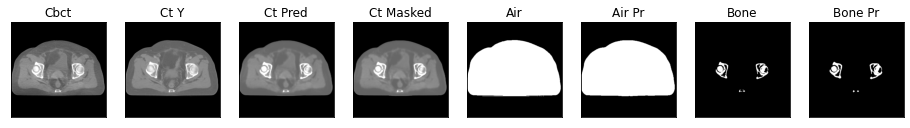

15it [00:56,  3.67s/it]

ssim score = 0.8811271786689758
psnr score = 26.832944869995117
snr score = 17.668672561645508
mae error = 0.01774875447154045
air dice score = 0.9964397964008591
bone dice score = 0.9415452123500776
contour dice score = 0.6215177774429321


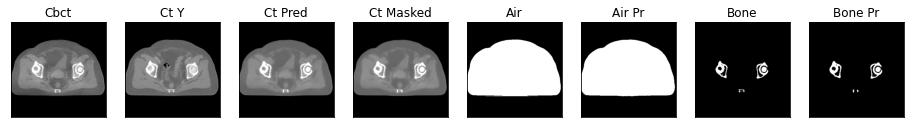

ssim score = 0.8702197074890137
psnr score = 25.951839447021484
snr score = 16.82512664794922
mae error = 0.018946105614304543
air dice score = 0.9967866944325711
bone dice score = 0.945054945055874
contour dice score = 0.6586306691169739


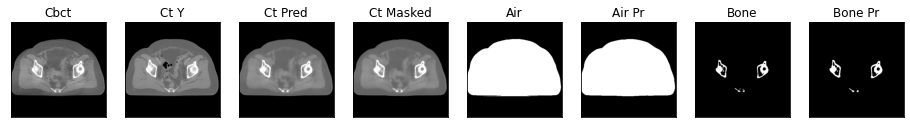

ssim score = 0.8557209372520447
psnr score = 24.320404052734375
snr score = 15.121252059936523
mae error = 0.021779272705316544
air dice score = 0.9967713249880314
bone dice score = 0.9273084479387185
contour dice score = 0.685519278049469


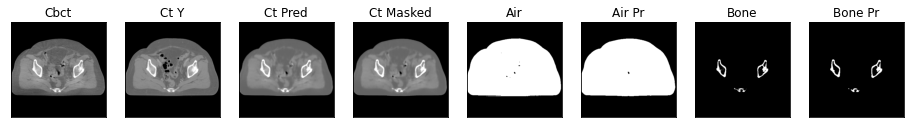

ssim score = 0.8480629324913025
psnr score = 23.889951705932617
snr score = 14.672808647155762
mae error = 0.02331007458269596
air dice score = 0.9964372645807011
bone dice score = 0.928744760645737
contour dice score = 0.7316592931747437


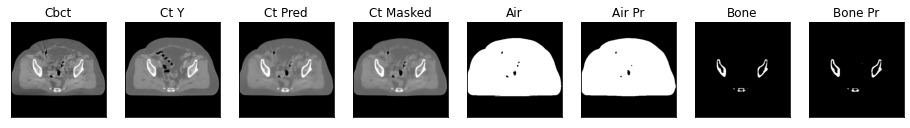

ssim score = 0.8469410538673401
psnr score = 24.51150894165039
snr score = 15.35927963256836
mae error = 0.022800393402576447
air dice score = 0.9964818813526282
bone dice score = 0.9370777027040313
contour dice score = 0.6871945261955261


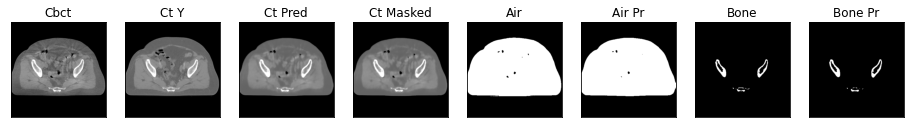

ssim score = 0.8467961549758911
psnr score = 24.56629180908203
snr score = 15.469159126281738
mae error = 0.02272152341902256
air dice score = 0.9964718985720883
bone dice score = 0.9318553516276239
contour dice score = 0.7154150009155273


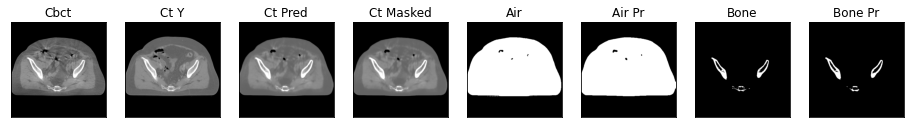

ssim score = 0.8430131673812866
psnr score = 23.89960289001465
snr score = 14.866899490356445
mae error = 0.02416788786649704
air dice score = 0.9966061406404777
bone dice score = 0.9299728342902207
contour dice score = 0.6865234375


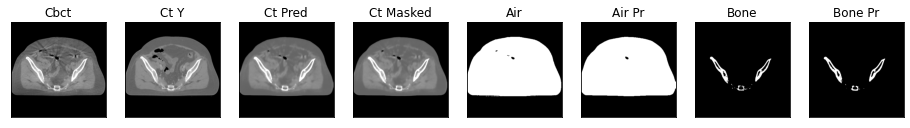

ssim score = 0.8430044651031494
psnr score = 23.825138092041016
snr score = 14.8652925491333
mae error = 0.0245126374065876
air dice score = 0.9967249194330202
bone dice score = 0.9206482257624944
contour dice score = 0.6849315166473389


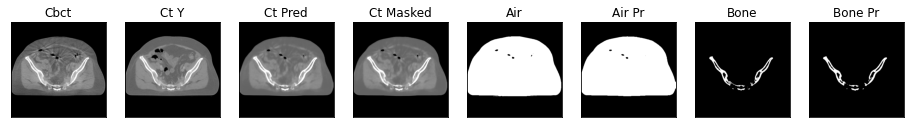

ssim score = 0.8428133130073547
psnr score = 23.797466278076172
snr score = 14.833331108093262
mae error = 0.02477319911122322
air dice score = 0.9964138146098098
bone dice score = 0.9128349788446709
contour dice score = 0.6760290265083313


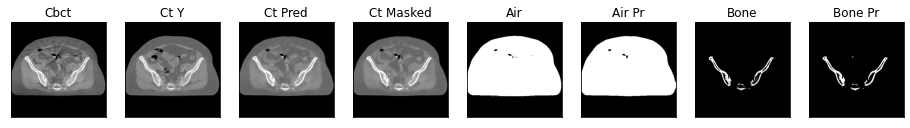

ssim score = 0.8417513370513916
psnr score = 23.711244583129883
snr score = 14.724931716918945
mae error = 0.025001103058457375
air dice score = 0.99685846347964
bone dice score = 0.9084021106763848
contour dice score = 0.6560846567153931


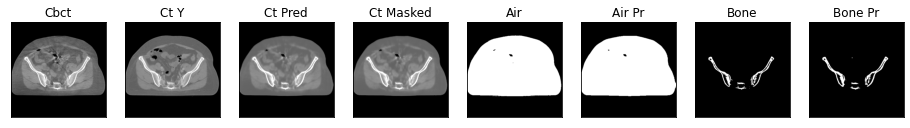

ssim score = 0.8468286395072937
psnr score = 24.474998474121094
snr score = 15.500317573547363
mae error = 0.023597076535224915
air dice score = 0.9970191552783949
bone dice score = 0.9130434782621051
contour dice score = 0.6573628783226013


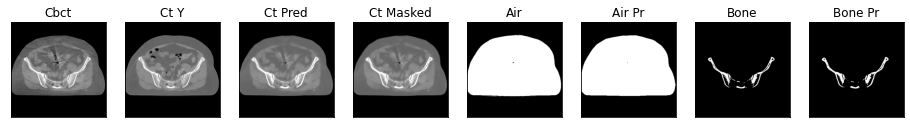

16it [00:59,  3.74s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

16it [00:05,  2.72it/s]


(0.8454397693276405,
 23.44624400138855,
 14.467239379882812,
 0.026016196119599044,
 0.9971226819502836,
 0.9248798074852157,
 0.7311323491066538,
 0.4943181835114956)

In [38]:
# import torchvision.models as models
# models.vgg16(pretrained=True)